In [1]:
# 设置工作路径
import os
os.chdir("D:\ZJM 组\中期")
# 获取并打印当前工作路径
current_path = os.getcwd()
print("当前工作路径:", current_path)


当前工作路径: D:\ZJM 组\中期


正在训练模型...


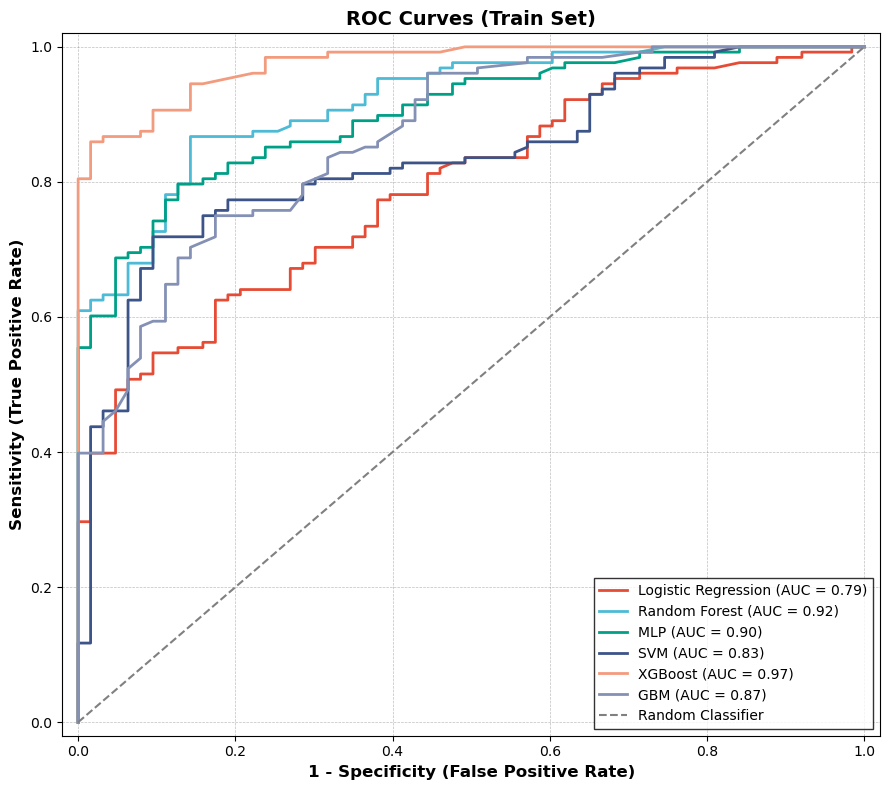

训练集 ROC 绘图完成！结果已保存至 '模型对比/roc_curves_train_nature_style.png'。


In [ ]:
# 导入Pandas库，用于数据处理
import pandas as pd
import numpy as np

# 导入模型选择与预处理
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 导入各类模型
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

# 导入评估模块
from sklearn.metrics import roc_curve, auc

# 导入绘图库
import matplotlib.pyplot as plt

# 忽略警告信息
import warnings
warnings.filterwarnings('ignore')

# ==========================================
# 1. 数据准备
# ==========================================

# 读取数据
df = pd.read_csv('data_complete.csv')

# 检查缺失值并删除
df = df.dropna()

# 分离特征和标签
X = df.drop(columns=['CHE'])
y = df['CHE']

# --- 特征工程 ---
# 将分类变量转换为独热编码
categorical_cols = ['Tips', 'HBV', 'Splenomegaly', 'History of Hepatic Encephalopathy']
# 重置索引
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

encoder = OneHotEncoder(drop='first', sparse_output=False)
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_cols]), 
                         columns=encoder.get_feature_names_out(categorical_cols))

# 拼接
X_numeric = X.drop(columns=categorical_cols)
X = pd.concat([X_numeric, X_encoded], axis=1)

# 标准化
val_cols = ['Blood Ammonia','Albumin']
scaler = StandardScaler()
X[val_cols] = scaler.fit_transform(X[val_cols])

# 类型转换
X = X.astype(np.float32)

# --- 数据集分割 ---
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# ==========================================
# 2. 模型构建与训练
# ==========================================

print("正在训练模型...")

# 1. 逻辑回归
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# 2. 随机森林
rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=6,         
    min_samples_leaf=5,  
    random_state=42
)
rf.fit(X_train, y_train)

# 3. MLP
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# 4. SVM
svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)

# 5. XGBoost
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    learning_rate=0.05,
    max_depth=4,         
    n_estimators=100,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# 6. LightGBM
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 20,
    'max_depth': 5,      
    'min_data_in_leaf': 30,
    'verbose': -1
}
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_model = lgb.train(params, lgb_train, num_boost_round=100)

# ==========================================
# 3. 绘制 Nature 风格 ROC 曲线 (基于 训练集 Train Set)
# ==========================================

# 定义 Nature 经典配色 (NPG)
nature_colors = {
    'Logistic Regression': '#E64B35',  # 红
    'Random Forest':       '#4DBBD5',  # 蓝
    'MLP':                 '#00A087',  # 绿
    'SVM':                 '#3C5488',  # 深蓝
    'XGBoost':             '#F39B7F',  # 橙
    'GBM':                 '#8491B4'   # 灰蓝
}

plt.figure(figsize=(9, 8))

# 定义绘图函数
def plot_roc_curve_styled(model, X, y, label, color, is_lgb=False):
    if is_lgb:
        y_pred = model.predict(X, num_iteration=model.best_iteration)
    else:
        y_pred = model.predict_proba(X)[:, 1]
    
    fpr, tpr, _ = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

# 【关键修改】这里全部改回了 X_train 和 y_train
plot_roc_curve_styled(log_reg, X_train, y_train, 'Logistic Regression', nature_colors['Logistic Regression'])
plot_roc_curve_styled(rf,      X_train, y_train, 'Random Forest',       nature_colors['Random Forest'])
plot_roc_curve_styled(mlp,     X_train, y_train, 'MLP',                 nature_colors['MLP'])
plot_roc_curve_styled(svm,     X_train, y_train, 'SVM',                 nature_colors['SVM'])
plot_roc_curve_styled(xgb_model, X_train, y_train, 'XGBoost',           nature_colors['XGBoost'])
plot_roc_curve_styled(lgb_model, X_train, y_train, 'GBM',               nature_colors['GBM'], is_lgb=True)

# 添加对角线
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1.5, label='Random Classifier')

# 美化图表设置 (标题改为 Train Set)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=12, fontweight='bold')
plt.ylabel('Sensitivity (True Positive Rate)', fontsize=12, fontweight='bold')
plt.title('ROC Curves (Train Set)', fontsize=14, fontweight='bold')

# 图例
plt.legend(loc='lower right', frameon=True, fancybox=False, edgecolor='black', fontsize=10)

# 网格线
plt.grid(True, which='major', linestyle='--', linewidth=0.5, color='grey', alpha=0.5)

# 保存与显示
plt.tight_layout()
import os
if not os.path.exists("模型对比"):
    os.makedirs("模型对比")
# 文件名也对应改为 train
plt.savefig("模型对比/roc_curves_train_nature_style.png", dpi=300)
plt.show()

print("训练集 ROC 绘图完成！结果已保存至 '模型对比/roc_curves_train_nature_style.png'。")

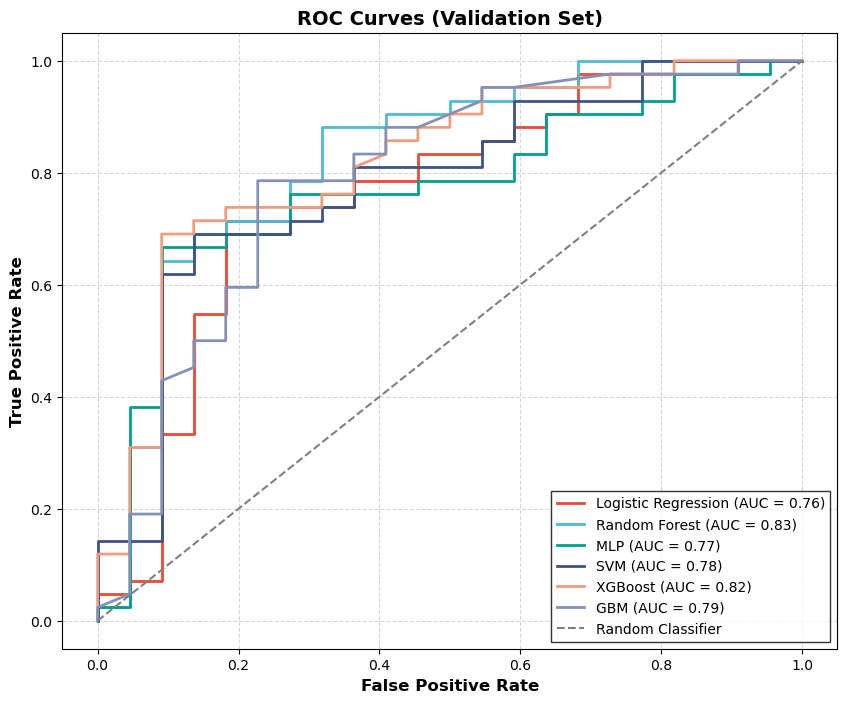

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os

# ==========================================
# 1. 定义 Nature 经典配色
# ==========================================
nature_colors = {
    'Logistic Regression': '#E64B35',  # 红
    'Random Forest':       '#4DBBD5',  # 蓝
    'MLP':                 '#00A087',  # 绿
    'SVM':                 '#3C5488',  # 深蓝
    'XGBoost':             '#F39B7F',  # 橙
    'GBM':                 '#8491B4'   # 灰蓝
}

# ==========================================
# 2. 定义带颜色参数的绘图函数
# ==========================================
def plot_roc_curve_colored(model, X, y, label, color, is_lgb=False):
    # 获取预测概率
    if is_lgb:
        y_pred = model.predict(X, num_iteration=model.best_iteration)
    else:
        y_pred = model.predict_proba(X)[:, 1]

    # 计算 FPR, TPR 和 AUC
    fpr, tpr, _ = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)

    # 绘图 (使用传入的 color 参数，线条设为 2 像素宽)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

# ==========================================
# 3. 开始绘制验证集 ROC 曲线
# ==========================================
plt.figure(figsize=(10, 8))

# 依次绘制各个模型，传入对应的颜色和验证集数据
plot_roc_curve_colored(log_reg,   X_val, y_val, 'Logistic Regression', nature_colors['Logistic Regression'])
plot_roc_curve_colored(rf,        X_val, y_val, 'Random Forest',       nature_colors['Random Forest'])
plot_roc_curve_colored(mlp,       X_val, y_val, 'MLP',                 nature_colors['MLP'])
plot_roc_curve_colored(svm,       X_val, y_val, 'SVM',                 nature_colors['SVM'])
plot_roc_curve_colored(xgb_model, X_val, y_val, 'XGBoost',             nature_colors['XGBoost'])
plot_roc_curve_colored(lgb_model, X_val, y_val, 'GBM',                 nature_colors['GBM'], is_lgb=True)

# 添加对角线 (灰色虚线)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1.5, label='Random Classifier')

# 美化图表
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves (Validation Set)', fontsize=14, fontweight='bold')

# 图例设置 (右下角，带边框)
plt.legend(loc='lower right', frameon=True, fancybox=False, edgecolor='black', fontsize=10)

# 网格线
plt.grid(True, linestyle='--', alpha=0.5)

# 保存文件
if not os.path.exists("模型对比"):
    os.makedirs("模型对比")
    
plt.savefig("模型对比/roc_curves_val_nature.png", dpi=300)
plt.show()

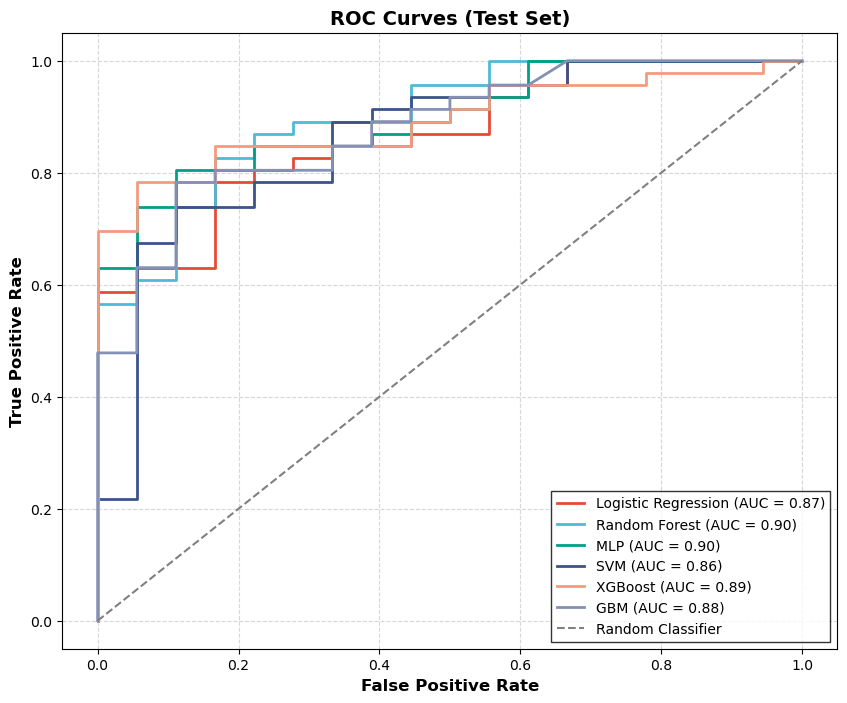

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os

# ==========================================
# 1. 定义 Nature 经典配色
# ==========================================
nature_colors = {
    'Logistic Regression': '#E64B35',  # 红
    'Random Forest':       '#4DBBD5',  # 蓝
    'MLP':                 '#00A087',  # 绿
    'SVM':                 '#3C5488',  # 深蓝
    'XGBoost':             '#F39B7F',  # 橙
    'GBM':                 '#8491B4'   # 灰蓝
}

# ==========================================
# 2. 定义带颜色参数的绘图函数
# ==========================================
def plot_roc_curve_with_color(model, X, y, label, color, is_lgb=False):
    # 获取预测概率
    if is_lgb:
        y_pred = model.predict(X, num_iteration=model.best_iteration)
    else:
        y_pred = model.predict_proba(X)[:, 1]

    # 计算 FPR, TPR 和 AUC
    fpr, tpr, _ = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)

    # 绘图
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

# ==========================================
# 3. 开始绘制测试集 ROC 曲线
# ==========================================
plt.figure(figsize=(10, 8))

# 依次绘制各个模型 (使用 X_test 和 y_test)
plot_roc_curve_with_color(log_reg,   X_test, y_test, 'Logistic Regression', nature_colors['Logistic Regression'])
plot_roc_curve_with_color(rf,        X_test, y_test, 'Random Forest',       nature_colors['Random Forest'])
plot_roc_curve_with_color(mlp,       X_test, y_test, 'MLP',                 nature_colors['MLP'])
plot_roc_curve_with_color(svm,       X_test, y_test, 'SVM',                 nature_colors['SVM'])
plot_roc_curve_with_color(xgb_model, X_test, y_test, 'XGBoost',             nature_colors['XGBoost'])
plot_roc_curve_with_color(lgb_model, X_test, y_test, 'GBM',                 nature_colors['GBM'], is_lgb=True)

# 添加对角线 (灰色虚线，样式更高级)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1.5, label='Random Classifier')

# 美化图表
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves (Test Set)', fontsize=14, fontweight='bold')

# 图例设置 (右下角，带边框)
plt.legend(loc='lower right', frameon=True, fancybox=False, edgecolor='black', fontsize=10)

# 网格线
plt.grid(True, linestyle='--', alpha=0.5)

# 保存文件
if not os.path.exists("模型对比"):
    os.makedirs("模型对比")
    
# 保存为高清 PDF
plt.savefig("模型对比/roc_curves_test_nature.png", dpi=300)
plt.show()

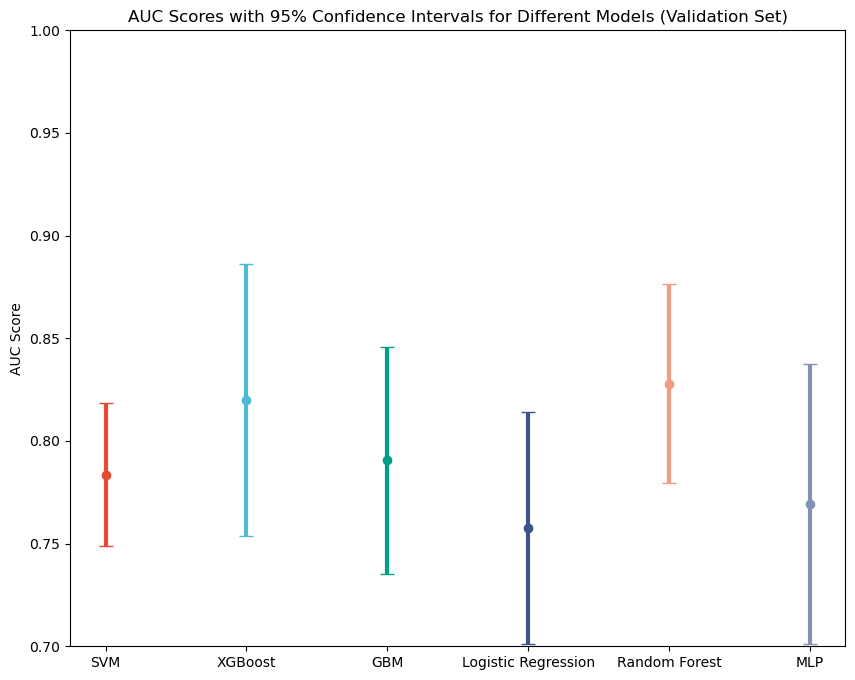

In [5]:
#### 绘制验证集数据类森林图
from scipy.stats import sem
from sklearn.metrics import roc_auc_score

# 计算 AUC 及其置信区间的函数
def compute_confidence_interval(data, confidence=0.95):
    n = len(data)  # 数据样本数
    mean = np.mean(data)  # 计算均值
    std_err = sem(data)  # 计算标准误差
    h = std_err * 1.96  # 对于95%的置信区间
    return mean, mean - h, mean + h

# 定义模型字典
models = {
    'SVM': svm,
    'XGBoost': xgb_model,
    'GBM': lgb_model,
    'Logistic Regression': log_reg,
    'Random Forest': rf,
    'MLP': mlp
}

# 计算每个模型的 AUC 及其置信区间
results = []
for name, model in models.items():
    if name == 'XGBoost':
        y_pred = model.predict_proba(X_val)[:, 1]  # 使用验证集数据
    elif name == 'GBM':
        y_pred = model.predict(X_val)  # 对GBM模型直接使用predict方法
    else:
        y_pred = model.predict_proba(X_val)[:, 1]  # 使用验证集数据
    
    auc_score = roc_auc_score(y_val, y_pred)  # 计算AUC得分
    auc_std = sem(y_pred)  # 计算AUC的标准误差
    ci = 1.96 * auc_std  # 95% 置信区间
    results.append((name, auc_score, auc_score - ci, auc_score + ci))  # 添加结果到结果列表

# 绘制横向森林图
fig, ax = plt.subplots(figsize=(10, 8))

# 模型名称
names = [result[0] for result in results]
# AUC 均值
means = [result[1] for result in results]

# AUC 置信区间下界
lower_bounds = [result[2] for result in results]
# AUC 置信区间上界
upper_bounds = [result[3] for result in results]

# 定义颜色
colors = [
    nature_colors['Logistic Regression'],
    nature_colors['Random Forest'],
    nature_colors['MLP'],
    nature_colors['SVM'],
    nature_colors['XGBoost'],
    nature_colors['GBM']
]


# 绘制横向水平线
for i, (mean, lower, upper, color) in enumerate(zip(means, lower_bounds, upper_bounds, colors)):
    ax.errorbar(i, mean, yerr=[[mean - lower], [upper - mean]], fmt='o', color=color, ecolor=color, elinewidth=3, capsize=5)

# 设置图形参数
ax.set_xticks(range(len(names)))  # 设置x轴刻度
ax.set_xticklabels(names)  # 设置x轴标签
ax.set_ylim(0.7, 1)  # 设置Y轴范围为0.7到1
ax.set_ylabel('AUC Score')  # 设置y轴标签
ax.set_title('AUC Scores with 95% Confidence Intervals for Different Models (Validation Set)')  # 设置图表标题

plt.savefig('模型对比/forestplot_val.png', dpi=300)  # 保存图表为PDF文件
plt.show()  # 显示图表

In [6]:
#### 验证集六模型AUC
import pandas as pd
from scipy.stats import sem
from sklearn.metrics import roc_auc_score

# 计算 AUC 及其置信区间的函数
def compute_confidence_interval(data, confidence=0.95):
    n = len(data)  # 数据样本数
    mean = np.mean(data)  # 计算均值
    std_err = sem(data)  # 计算标准误差
    h = std_err * 1.96  # 对于95%的置信区间
    return mean, mean - h, mean + h

# 定义模型字典
models = {
    'SVM': svm,
    'XGBoost': xgb_model,
    'GBM': lgb_model,
    'Logistic Regression': log_reg,
    'Random Forest': rf,
    'MLP': mlp
}

# 计算每个模型的 AUC 及其置信区间
results = []
for name, model in models.items():
    if name == 'XGBoost':
        y_pred = model.predict_proba(X_val)[:, 1]  # 使用验证集数据
    elif name == 'GBM':
        y_pred = model.predict(X_val)  # 对GBM模型直接使用predict方法
    else:
        y_pred = model.predict_proba(X_val)[:, 1]  # 使用验证集数据
    
    auc_score = roc_auc_score(y_val, y_pred)  # 计算AUC得分
    auc_std = sem(y_pred)  # 计算AUC的标准误差
    ci = 1.96 * auc_std  # 95% 置信区间
    results.append((name, auc_score, auc_score - ci, auc_score + ci))  # 添加结果到结果列表

# 创建 DataFrame 并展示 AUC 数据
df_results = pd.DataFrame(results, columns=['Model', 'AUC Score', 'CI Lower Bound', 'CI Upper Bound'])
print(df_results)

# 可选: 保存为 CSV 文件
df_results.to_csv('模型对比/auc_results_validation.csv', index=False)

                 Model  AUC Score  CI Lower Bound  CI Upper Bound
0                  SVM   0.783550        0.748677        0.818423
1              XGBoost   0.819805        0.753547        0.886063
2                  GBM   0.790584        0.735212        0.845957
3  Logistic Regression   0.757576        0.701075        0.814076
4        Random Forest   0.827922        0.779418        0.876426
5                  MLP   0.769481        0.701262        0.837699


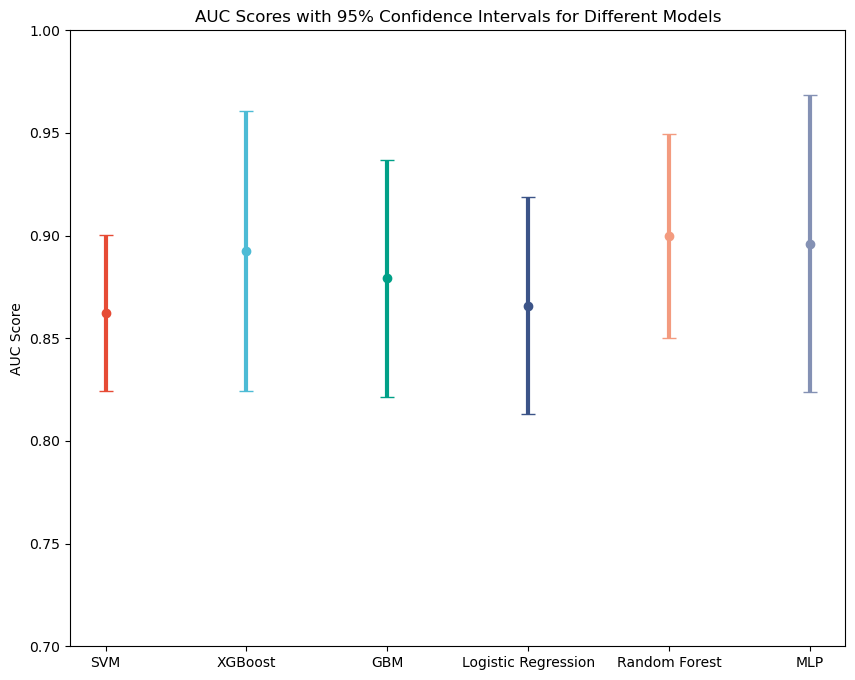

In [7]:
#### 绘制测试集数据类森林图
from scipy.stats import sem
from sklearn.metrics import roc_auc_score

# 计算 AUC 及其置信区间的函数
def compute_confidence_interval(data, confidence=0.95):
    n = len(data)  # 数据样本数
    mean = np.mean(data)  # 计算均值
    std_err = sem(data)  # 计算标准误差
    h = std_err * 1.96  # 对于95%的置信区间
    return mean, mean - h, mean + h

# 定义模型字典
models = {
    'SVM': svm,
    'XGBoost': xgb_model,
    'GBM': lgb_model,
    'Logistic Regression': log_reg,
    'Random Forest': rf,
    'MLP': mlp
}

# 计算每个模型的 AUC 及其置信区间
results = []
for name, model in models.items():
    if name == 'XGBoost':
        y_pred = model.predict_proba(X_test)[:, 1]  # 使用predict_proba方法，并选择概率列
    elif name == 'GBM':
        y_pred = model.predict(X_test)  # 对GBM模型直接使用predict方法
    else:
        y_pred = model.predict_proba(X_test)[:, 1]  # 使用predict_proba方法，并选择概率列
    
    auc_score = roc_auc_score(y_test, y_pred)  # 计算AUC得分
    auc_std = sem(y_pred)  # 计算AUC的标准误差
    ci = 1.96 * auc_std  # 95% 置信区间
    results.append((name, auc_score, auc_score - ci, auc_score + ci))  # 添加结果到结果列表

# 绘制横向森林图
fig, ax = plt.subplots(figsize=(10, 8))

# 模型名称
names = [result[0] for result in results]
# AUC 均值
means = [result[1] for result in results]
# AUC 置信区间下界
lower_bounds = [result[2] for result in results]
# AUC 置信区间上界
upper_bounds = [result[3] for result in results]

# 定义颜色
colors = [
    nature_colors['Logistic Regression'],
    nature_colors['Random Forest'],
    nature_colors['MLP'],
    nature_colors['SVM'],
    nature_colors['XGBoost'],
    nature_colors['GBM']
]


# 绘制横向水平线
for i, (mean, lower, upper, color) in enumerate(zip(means, lower_bounds, upper_bounds, colors)):
    ax.errorbar(i, mean, yerr=[[mean - lower], [upper - mean]], fmt='o', color=color, ecolor=color, elinewidth=3, capsize=5)

# 设置图形参数
ax.set_xticks(range(len(names)))  # 设置x轴刻度
ax.set_xticklabels(names)  # 设置x轴标签
ax.set_ylim(0.7, 1)  # 设置Y轴范围为0.7到1
ax.set_ylabel('AUC Score')  # 设置y轴标签
ax.set_title('AUC Scores with 95% Confidence Intervals for Different Models')  # 设置图表标题

plt.savefig('模型对比/forestplot.pdf')  # 保存图表为PDF文件
plt.show()  # 显示图表

In [6]:
#### 测试集六模型AUC
import pandas as pd
from scipy.stats import sem
from sklearn.metrics import roc_auc_score

# 计算 AUC 及其置信区间的函数
def compute_confidence_interval(data, confidence=0.95):
    n = len(data)  # 数据样本数
    mean = np.mean(data)  # 计算均值
    std_err = sem(data)  # 计算标准误差
    h = std_err * 1.96  # 对于95%的置信区间
    return mean, mean - h, mean + h

# 定义模型字典
models = {
    'SVM': svm,
    'XGBoost': xgb_model,
    'GBM': lgb_model,
    'Logistic Regression': log_reg,
    'Random Forest': rf,
    'MLP': mlp
}

# 计算每个模型的 AUC 及其置信区间
results = []
for name, model in models.items():
    if name == 'XGBoost':
        y_pred = model.predict_proba(X_test)[:, 1]  # 使用测试集数据
    elif name == 'GBM':
        y_pred = model.predict(X_test)  # 对GBM模型直接使用predict方法
    else:
        y_pred = model.predict_proba(X_test)[:, 1]  # 使用测试集数据
    
    auc_score = roc_auc_score(y_test, y_pred)  # 计算AUC得分
    auc_std = sem(y_pred)  # 计算AUC的标准误差
    ci = 1.96 * auc_std  # 95% 置信区间
    results.append((name, auc_score, auc_score - ci, auc_score + ci))  # 添加结果到结果列表

# 创建 DataFrame 并展示 AUC 数据
df_results = pd.DataFrame(results, columns=['Model', 'AUC Score', 'CI Lower Bound', 'CI Upper Bound'])
print(df_results)

# 可选: 保存为 CSV 文件
df_results.to_csv('模型对比/auc_results_test.csv', index=False)

                 Model  AUC Score  CI Lower Bound  CI Upper Bound
0                  SVM   0.862319        0.824542        0.900096
1              XGBoost   0.892512        0.824308        0.960716
2                  GBM   0.879227        0.821439        0.937015
3  Logistic Regression   0.865942        0.812998        0.918887
4        Random Forest   0.899758        0.849972        0.949545
5                  MLP   0.896135        0.823838        0.968433


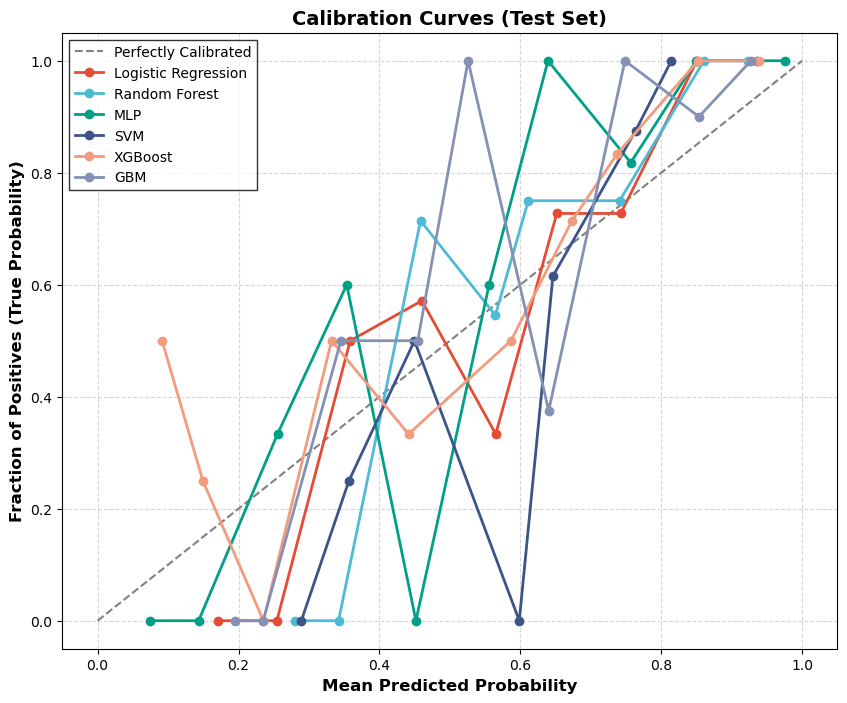

校准曲线绘制完成！已保存至 '模型对比/calibration_curves_test_nature.png'


In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.calibration import calibration_curve

# ==========================================
# 1. 准备工作：颜色与模型字典
# ==========================================

# 再次定义颜色 (确保变量存在)
nature_colors = {
    'Logistic Regression': '#E64B35',  # 红
    'Random Forest':       '#4DBBD5',  # 蓝
    'MLP':                 '#00A087',  # 绿
    'SVM':                 '#3C5488',  # 深蓝
    'XGBoost':             '#F39B7F',  # 橙
    'GBM':                 '#8491B4'   # 灰蓝
}

# 将之前训练好的模型放入字典
models = {
    'Logistic Regression': log_reg,
    'Random Forest': rf,
    'MLP': mlp,
    'SVM': svm,
    'XGBoost': xgb_model,
    'GBM': lgb_model
}

# ==========================================
# 2. 定义预测辅助函数
# ==========================================
def get_predictions(model, X, model_name):
    # GBM (LightGBM原生接口) predict 直接返回概率
    if model_name == 'GBM':
        return model.predict(X, num_iteration=model.best_iteration)
    # 其他 sklearn 接口模型需要用 predict_proba 获取正类概率
    else:
        return model.predict_proba(X)[:, 1]

# ==========================================
# 3. 绘制测试集校准曲线
# ==========================================

plt.figure(figsize=(10, 8))

# 绘制参考线 (Perfectly calibrated)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', linewidth=1.5, label='Perfectly Calibrated')

# 循环绘制每个模型的曲线
for name, model in models.items():
    # 1. 获取预测概率
    y_pred = get_predictions(model, X_test, name)
    
    # 2. 限制范围 (防止极个别数值溢出)
    y_pred = np.clip(y_pred, 0, 1)

    # 3. 计算校准曲线坐标点
    # n_bins=10 表示将概率分成10个区间
    prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10)

    # 4. 绘图
    # 使用 nature_colors[name] 获取对应颜色
    plt.plot(prob_pred, prob_true, 
             marker='o',           # 添加圆点标记，方便看区间点
             markersize=6,         # 标记大小
             linewidth=2,          # 线宽
             color=nature_colors[name], # 关键：指定颜色
             label=name)

# ==========================================
# 4. 图表美化与保存
# ==========================================

plt.xlabel('Mean Predicted Probability', fontsize=12, fontweight='bold')
plt.ylabel('Fraction of Positives (True Probability)', fontsize=12, fontweight='bold')
plt.title('Calibration Curves (Test Set)', fontsize=14, fontweight='bold')

# 图例设置
plt.legend(loc='best', frameon=True, fancybox=False, edgecolor='black', fontsize=10)

# 网格设置
plt.grid(True, linestyle='--', alpha=0.5)

# 坐标轴范围
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

# 保存
import os
if not os.path.exists("模型对比"):
    os.makedirs("模型对比")

plt.savefig('模型对比/calibration_curves_test_nature.png', dpi=300)
plt.show()

print("校准曲线绘制完成！已保存至 '模型对比/calibration_curves_test_nature.png'")

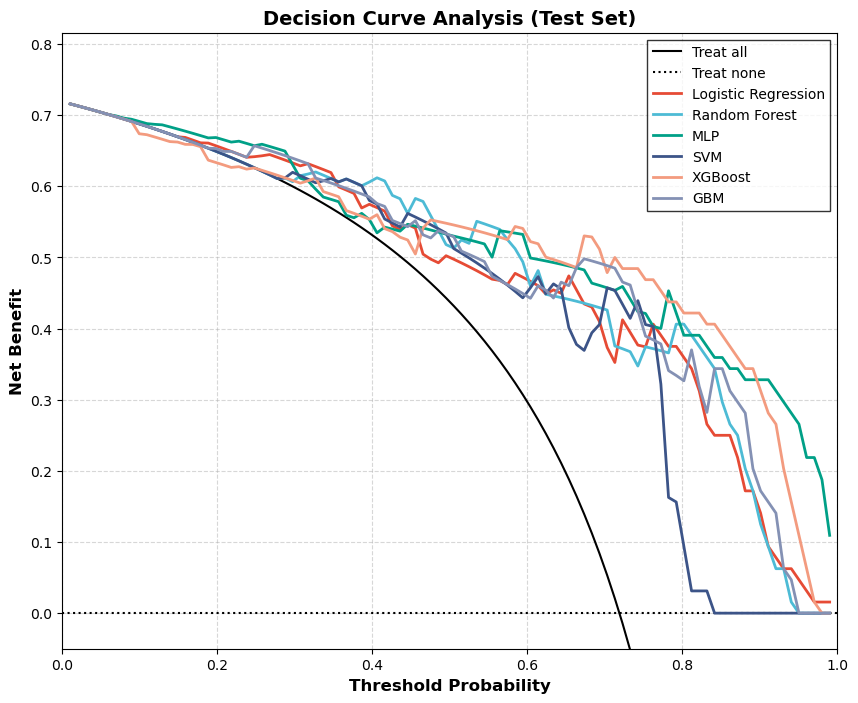

DCA 曲线绘制完成！已保存至 '模型对比/dca_curves_test_nature.png'


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import os

# ==========================================
# 1. 准备工作：颜色与模型
# ==========================================

# 确保颜色字典存在
nature_colors = {
    'Logistic Regression': '#E64B35',  # 红
    'Random Forest':       '#4DBBD5',  # 蓝
    'MLP':                 '#00A087',  # 绿
    'SVM':                 '#3C5488',  # 深蓝
    'XGBoost':             '#F39B7F',  # 橙
    'GBM':                 '#8491B4'   # 灰蓝
}

# 确保模型字典存在
models = {
    'Logistic Regression': log_reg,
    'Random Forest': rf,
    'MLP': mlp,
    'SVM': svm,
    'XGBoost': xgb_model,
    'GBM': lgb_model
}

# ==========================================
# 2. 定义计算净收益的函数
# ==========================================

def calculate_net_benefit_model(thresh_group, y_pred_score, y_label):
    net_benefit_model = np.array([])
    for thresh in thresh_group:
        y_pred_label = y_pred_score > thresh
        tn, fp, fn, tp = confusion_matrix(y_label, y_pred_label).ravel()
        n = len(y_label)
        net_benefit = (tp / n) - (fp / n) * (thresh / (1 - thresh))
        net_benefit_model = np.append(net_benefit_model, net_benefit)
    return net_benefit_model

def calculate_net_benefit_all(thresh_group, y_label):
    net_benefit_all = np.array([])
    # 计算 "Treat All" 的策略：假设所有人都预测为阳性
    # 此时 TP = 实际阳性数, FP = 实际阴性数
    actual_pos = np.sum(y_label)
    actual_neg = len(y_label) - actual_pos
    n = len(y_label)
    
    for thresh in thresh_group:
        net_benefit = (actual_pos / n) - (actual_neg / n) * (thresh / (1 - thresh))
        net_benefit_all = np.append(net_benefit_all, net_benefit)
    return net_benefit_all

# ==========================================
# 3. 绘制测试集 DCA 曲线
# ==========================================

# 设置绘图区域
fig, ax = plt.subplots(figsize=(10, 8))

# 1. 定义阈值范围 (避免 0 和 1，防止除以零)
thresh_group = np.linspace(0.01, 0.99, 100)

# 2. 绘制 "Treat all" (所有人都治疗)
net_benefit_all = calculate_net_benefit_all(thresh_group, y_test)
ax.plot(thresh_group, net_benefit_all, color='black', linestyle='-', lw=1.5, label='Treat all')

# 3. 绘制 "Treat none" (所有人都不治疗 -> 净收益为 0)
ax.plot((0, 1), (0, 0), color='black', linestyle=':', lw=1.5, label='Treat none')

# 4. 循环绘制各个模型的 DCA 曲线
y_max_benefit = np.max(net_benefit_all) # 用于后续设置y轴范围

for name, model in models.items():
    # 获取预测概率 (区分 GBM 和其他模型)
    if name == 'GBM':
        y_pred_prob = model.predict(X_test, num_iteration=model.best_iteration)
    else:
        y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    # 计算净收益
    nb_model = calculate_net_benefit_model(thresh_group, y_pred_prob, y_test)
    
    # 记录最大收益用于调整坐标轴
    y_max_benefit = max(y_max_benefit, np.max(nb_model))
    
    # 绘图 (使用 nature_colors)
    ax.plot(thresh_group, nb_model, color=nature_colors[name], lw=2, label=name)

# ==========================================
# 4. 图表美化与保存
# ==========================================

# 设置坐标轴范围
ax.set_xlim(0, 1)
# y轴下限设为稍微负一点(-0.05)即可，不需要显示过低的负收益，上限设为最大收益+0.1
ax.set_ylim(-0.05, y_max_benefit + 0.1) 

# 设置标签和标题
ax.set_xlabel('Threshold Probability', fontsize=12, fontweight='bold')
ax.set_ylabel('Net Benefit', fontsize=12, fontweight='bold')
ax.set_title('Decision Curve Analysis (Test Set)', fontsize=14, fontweight='bold')

# 网格设置
ax.grid(True, linestyle='--', alpha=0.5)

# 图例设置
ax.legend(loc='upper right', frameon=True, fancybox=False, edgecolor='black', fontsize=10)

# 保存
if not os.path.exists("模型对比"):
    os.makedirs("模型对比")

plt.savefig("模型对比/dca_curves_test_nature.png", dpi=300)
plt.show()

print("DCA 曲线绘制完成！已保存至 '模型对比/dca_curves_test_nature.png'")

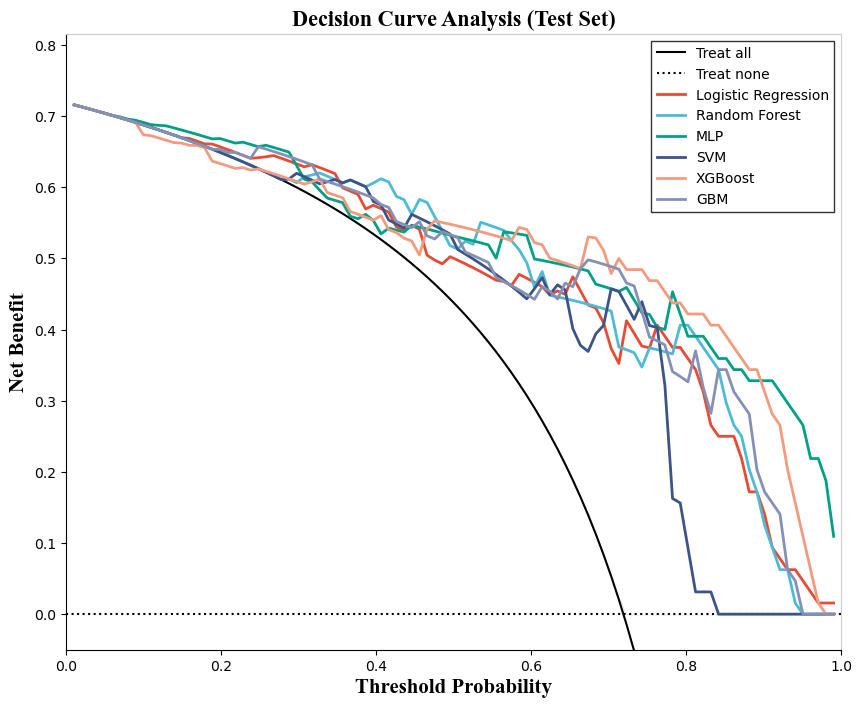

DCA 绘图完成！(无网格线，已应用 Nature 配色)


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import os

# ==========================================
# 1. 准备工作
# ==========================================

# 定义颜色 (Nature 风格)
nature_colors = {
    'Logistic Regression': '#E64B35',  # 红
    'Random Forest':       '#4DBBD5',  # 蓝
    'MLP':                 '#00A087',  # 绿
    'SVM':                 '#3C5488',  # 深蓝
    'XGBoost':             '#F39B7F',  # 橙
    'GBM':                 '#8491B4'   # 灰蓝
}

# 定义模型字典 (确保这些模型变量在之前已经训练好)
models = {
    'Logistic Regression': log_reg,
    'Random Forest': rf,
    'MLP': mlp,
    'SVM': svm,
    'XGBoost': xgb_model,
    'GBM': lgb_model
}

# ==========================================
# 2. 定义计算函数 (保留您的原始逻辑)
# ==========================================

# 计算模型的净收益
def calculate_net_benefit_model(thresh_group, y_pred_score, y_label):
    net_benefit_model = np.array([])
    for thresh in thresh_group:
        y_pred_label = y_pred_score > thresh
        tn, fp, fn, tp = confusion_matrix(y_label, y_pred_label).ravel()
        n = len(y_label)
        net_benefit = (tp / n) - (fp / n) * (thresh / (1 - thresh))
        net_benefit_model = np.append(net_benefit_model, net_benefit)
    return net_benefit_model

# 计算所有样本净收益 (Treat All)
def calculate_net_benefit_all(thresh_group, y_label):
    net_benefit_all = np.array([])
    # 这里也可以直接用公式：(实际阳性数/总数) - (实际阴性数/总数) * (pt / (1-pt))
    tn, fp, fn, tp = confusion_matrix(y_label, y_label).ravel() 
    total = tp + tn
    for thresh in thresh_group:
        net_benefit = (tp / total) - (tn / total) * (thresh / (1 - thresh))
        net_benefit_all = np.append(net_benefit_all, net_benefit)
    return net_benefit_all

# ==========================================
# 3. 绘制测试集的 DCA 曲线
# ==========================================

fig, ax = plt.subplots(figsize=(10, 8))

# 定义阈值组
thresh_group = np.linspace(0.01, 0.99, 100)

# --- 绘制基准线 (Treat all / Treat none) ---

# Treat all
net_benefit_all = calculate_net_benefit_all(thresh_group, y_test)
ax.plot(thresh_group, net_benefit_all, color='black', label='Treat all', lw=1.5)

# Treat none
ax.plot((0, 1), (0, 0), color='black', linestyle=':', label='Treat none', lw=1.5)

# 填充 Treat all 和 Treat none 之间的区域 (灰色背景)
y2 = np.maximum(net_benefit_all, 0)
y1 = np.maximum(0, y2)
ax.fill_between(thresh_group, y1, y2, color='gray', alpha=0.1)

# --- 循环绘制各个模型 (应用 Nature 颜色) ---

# 用于记录最大收益以调整Y轴
y_max = np.max(net_benefit_all)

for name, model in models.items():
    # 1. 获取预测概率
    if name == 'GBM':
        # LightGBM 原生接口使用 predict
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    else:
        # Sklearn 接口使用 predict_proba
        y_pred = model.predict_proba(X_test)[:, 1]
    
    # 2. 计算净收益
    nb_model = calculate_net_benefit_model(thresh_group, y_pred, y_test)
    
    # 3. 更新最大值 (用于设置坐标轴上限)
    y_max = max(y_max, np.max(nb_model))
    
    # 4. 绘图 (关键：使用 nature_colors)
    ax.plot(thresh_group, nb_model, color=nature_colors[name], label=name, lw=2)


# ==========================================
# 4. 图表设置 (无网格线，字体设置)
# ==========================================

# 设置 Y 轴范围
ax.set_xlim(0, 1)
ax.set_ylim(-0.05, y_max + 0.1) # 下限设为 -0.05 避免显示过多负值区域

# 设置标签 (Times New Roman)
ax.set_xlabel('Threshold Probability', fontdict={'family': 'Times New Roman', 'fontsize': 15, 'weight': 'bold'})
ax.set_ylabel('Net Benefit', fontdict={'family': 'Times New Roman', 'fontsize': 15, 'weight': 'bold'})
ax.set_title('Decision Curve Analysis (Test Set)', fontdict={'family': 'Times New Roman', 'fontsize': 16, 'weight': 'bold'})

# 【关键】确保没有网格线
ax.grid(False)

# 美化边框颜色
ax.spines['right'].set_color((0.8, 0.8, 0.8))
ax.spines['top'].set_color((0.8, 0.8, 0.8))

# 图例设置
ax.legend(loc='upper right', frameon=True, fancybox=False, edgecolor='black', fontsize=10)

# 保存与显示
if not os.path.exists("模型对比"):
    os.makedirs("模型对比")

plt.savefig("模型对比/dca_curves_test.png", dpi=300)
plt.show()

print("DCA 绘图完成！(无网格线，已应用 Nature 配色)")

In [10]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from lifelines import CoxPHFitter
# from sklearn.svm import SVC
# import lightgbm as lgb
# from sksurv.ensemble import RandomSurvivalForest
# from sklearn.metrics import roc_curve, auc, confusion_matrix
# import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')

# # 读取数据
# df = pd.read_excel('生存曲线/filter_data.xlsx')

# # 定义时间和事件列
# time_col = 'time'
# event_col = 'Status'

# # 检查缺失值并删除包含缺失值的行
# df = df.dropna()

# # 分离特征和标签
# X = df.drop(columns=[time_col, event_col])
# y = df[[time_col, event_col]]

# # 标准化数值特征
# scaler = StandardScaler()
# X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# # 将数据转换为 float32 类型
# X = X.astype(np.float32)

# # 分割数据集
# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# # 合并X和y训练数据
# train_data = X_train.copy()
# train_data[time_col] = y_train[time_col]
# train_data[event_col] = y_train[event_col]

# # 构建Cox回归模型
# cph = CoxPHFitter()
# cph.fit(train_data, duration_col=time_col, event_col=event_col)

# # 将时间和事件数据转换为structured数组
# y_train_structured = np.array([(e, t) for e, t in zip(y_train[event_col], y_train[time_col])], dtype=[('event', 'bool'), ('time', 'f8')])
# y_val_structured = np.array([(e, t) for e, t in zip(y_val[event_col], y_val[time_col])], dtype=[('event', 'bool'), ('time', 'f8')])
# y_test_structured = np.array([(e, t) for e, t in zip(y_test[event_col], y_test[time_col])], dtype=[('event', 'bool'), ('time', 'f8')])

# # 构建随机生存森林模型
# rsf = RandomSurvivalForest(n_estimators=100, random_state=42)
# rsf.fit(X_train, y_train_structured)

# # 构建SVM模型（通过 SVC 模拟）
# svm = SVC(probability=True, random_state=42)
# svm.fit(X_train, y_train[event_col])

# # 构建GBM模型
# params = {
#     'objective': 'binary',
#     'metric': 'binary_logloss',
#     'boosting_type': 'gbdt',
#     'learning_rate': 0.1,
#     'num_leaves': 31,
#     'max_depth': -1,
#     'min_data_in_leaf': 20,
#     'num_threads': 4,
#     'verbose': -1
# }
# lgb_train = lgb.Dataset(X_train, label=y_train[event_col])
# lgb_model = lgb.train(params, lgb_train, num_boost_round=100)

# # RSF prediction method adjustment
# def rsf_predict_proba(model, X, time_point):
#     surv_funcs = model.predict_survival_function(X)
#     y_pred = np.array([fn(time_point) for fn in surv_funcs])
#     return y_pred

# # DCA相关函数
# def calculate_net_benefit_model(thresh_group, y_pred_score, y_label):
#     net_benefit_model = np.array([])
#     for thresh in thresh_group:
#         y_pred_label = y_pred_score > thresh
#         tn, fp, fn, tp = confusion_matrix(y_label, y_pred_label).ravel()
#         n = len(y_label)
#         net_benefit = (tp / n) - (fp / n) * (thresh / (1 - thresh))
#         net_benefit_model = np.append(net_benefit_model, net_benefit)
#     return net_benefit_model

# def calculate_net_benefit_all(thresh_group, y_label):
#     net_benefit_all = np.array([])
#     tn, fp, fn, tp = confusion_matrix(y_label, y_label).ravel()
#     total = tp + tn
#     for thresh in thresh_group:
#         net_benefit = (tp / total) - (tn / total) * (thresh / (1 - thresh))
#         net_benefit_all = np.append(net_benefit_all, net_benefit)
#     return net_benefit_all

# def plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all, label):
#     # Plot
#     ax.plot(thresh_group, net_benefit_model, label=f'{label}')
#     ax.plot(thresh_group, net_benefit_all, color='black', label='Treat all')
#     ax.plot((0, 1), (0, 0), color='black', linestyle=':', label='Treat none')

#     # treat all和treat none
#     y2 = np.maximum(net_benefit_all, 0)
#     y1 = np.maximum(net_benefit_model, y2)
#     ax.fill_between(thresh_group, y1, y2, alpha=0.2)

#     # Figure Configuration
#     ax.set_xlim(0, 1)
#     ax.set_ylim(net_benefit_model.min() - 0.15, net_benefit_model.max() + 0.15)  # adjust the y axis limitation
#     ax.set_xlabel('Threshold Probability', fontdict={'family': 'Times New Roman', 'fontsize': 15})
#     ax.set_ylabel('Net Benefit', fontdict={'family': 'Times New Roman', 'fontsize': 15})
#     ax.grid('major')
#     ax.spines['right'].set_color((0.8, 0.8, 0.8))
#     ax.spines['top'].set_color((0.8, 0.8, 0.8))
#     ax.legend(loc='upper right')

#     return ax

# # 设定时间点
# time_point = 365  # 比如1年

# # 预测生存概率
# test_surv_prob = rsf_predict_proba(rsf, X_test, time_point)

# # 绘制测试集的DCA曲线
# fig, ax = plt.subplots(figsize=(10, 8))

# # 定义阈值组
# thresh_group = np.linspace(0.01, 0.99, 100)

# # Cox回归模型
# cox_preds_test = cph.predict_partial_hazard(X_test).values.flatten()
# net_benefit_model = calculate_net_benefit_model(thresh_group, 1 - cox_preds_test, y_test[event_col])
# net_benefit_all = calculate_net_benefit_all(thresh_group, y_test[event_col])
# ax = plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all, 'Cox')

# # 随机生存森林模型
# net_benefit_model = calculate_net_benefit_model(thresh_group, 1 - test_surv_prob, y_test[event_col])
# ax = plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all, 'RSF')

# # SVM模型
# svm_preds_test = svm.predict_proba(X_test)[:, 1]
# net_benefit_model = calculate_net_benefit_model(thresh_group, svm_preds_test, y_test[event_col])
# ax = plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all, 'SVM')

# # GBM模型
# gbm_preds_test = lgb_model.predict(X_test)
# net_benefit_model = calculate_net_benefit_model(thresh_group, gbm_preds_test, y_test[event_col])
# ax = plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all, 'GBM')

# # 保存图像并显示
# plt.savefig("模型对比/dca_curves_test.pdf")
# plt.show()

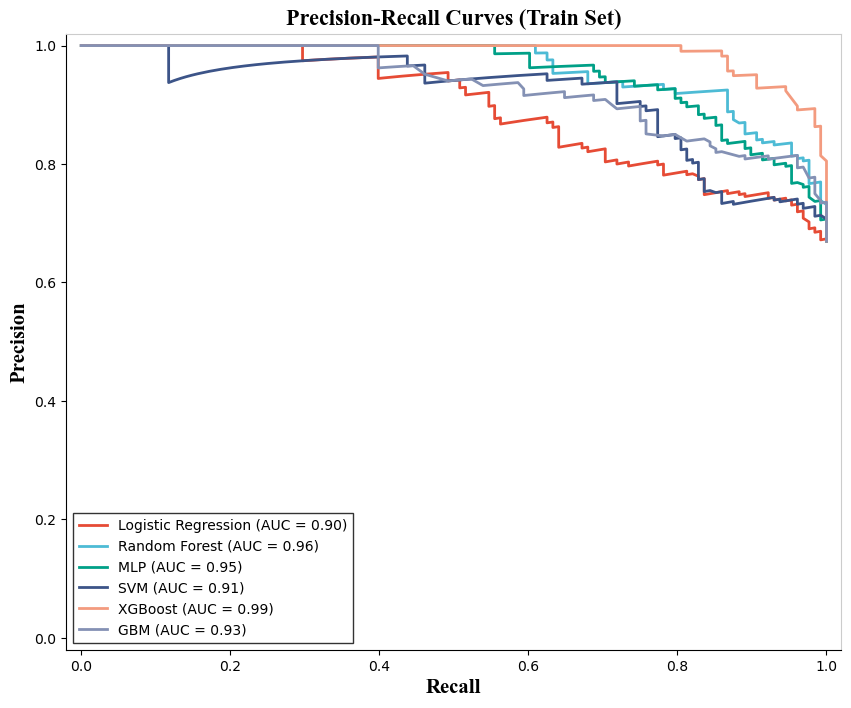

训练集 PR 曲线绘制完成！已保存至 '模型对比/pr_curves_train.png'


In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, auc
import os

# ==========================================
# 1. 准备工作
# ==========================================

# 确保颜色字典存在
nature_colors = {
    'Logistic Regression': '#E64B35',  # 红
    'Random Forest':       '#4DBBD5',  # 蓝
    'MLP':                 '#00A087',  # 绿
    'SVM':                 '#3C5488',  # 深蓝
    'XGBoost':             '#F39B7F',  # 橙
    'GBM':                 '#8491B4'   # 灰蓝
}

# 确保模型字典存在
models = {
    'Logistic Regression': log_reg,
    'Random Forest': rf,
    'MLP': mlp,
    'SVM': svm,
    'XGBoost': xgb_model,
    'GBM': lgb_model
}

# ==========================================
# 2. 定义绘图函数 (增加了 color 参数)
# ==========================================

def plot_pr_curve(ax, y_true, y_scores, label, color):
    """绘制PR曲线"""
    # 计算 Precision-Recall 曲线
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    
    # 计算 AUC 值
    auc_score = auc(recall, precision)
    
    # 绘制 PR 曲线 (使用传入的 color)
    ax.plot(recall, precision, label=f'{label} (AUC = {auc_score:.2f})', color=color, lw=2)

    # 图表配置 (保留您的样式设置)
    ax.set_xlabel("Recall", fontdict={'family': 'Times New Roman', 'fontsize': 15, 'weight': 'bold'})
    ax.set_ylabel("Precision", fontdict={'family': 'Times New Roman', 'fontsize': 15, 'weight': 'bold'})
    
    # 设置边框颜色
    ax.spines['right'].set_color((0.8, 0.8, 0.8))
    ax.spines['top'].set_color((0.8, 0.8, 0.8))
    
    # 设置图例位置
    ax.legend(loc='lower left', frameon=True, fancybox=False, edgecolor='black', fontsize=10)

    return ax

# ==========================================
# 3. 绘制训练集的 PR 曲线
# ==========================================

fig_train, ax_train = plt.subplots(figsize=(10, 8))

# 循环绘制每个模型
for name, model in models.items():
    # 1. 获取预测概率
    if name == 'GBM':
        # LightGBM 原生接口
        y_scores = model.predict(X_train, num_iteration=model.best_iteration)
    else:
        # Sklearn 接口
        y_scores = model.predict_proba(X_train)[:, 1]
    
    # 2. 调用函数绘图 (传入对应的颜色)
    plot_pr_curve(ax_train, y_train, y_scores, name, color=nature_colors[name])

# ==========================================
# 4. 全局样式调整与保存
# ==========================================

# 设置标题
ax_train.set_title('Precision-Recall Curves (Train Set)', fontdict={'family': 'Times New Roman', 'fontsize': 16, 'weight': 'bold'})

# 移除网格线 (保持与DCA风格一致，更简洁)
ax_train.grid(False)

# 设置坐标轴范围
ax_train.set_xlim([-0.02, 1.02])
ax_train.set_ylim([-0.02, 1.02])

# 保存图像
if not os.path.exists("模型对比"):
    os.makedirs("模型对比")

plt.savefig("模型对比/pr_curves_train.png", dpi=300)
plt.show()

print("训练集 PR 曲线绘制完成！已保存至 '模型对比/pr_curves_train.png'")

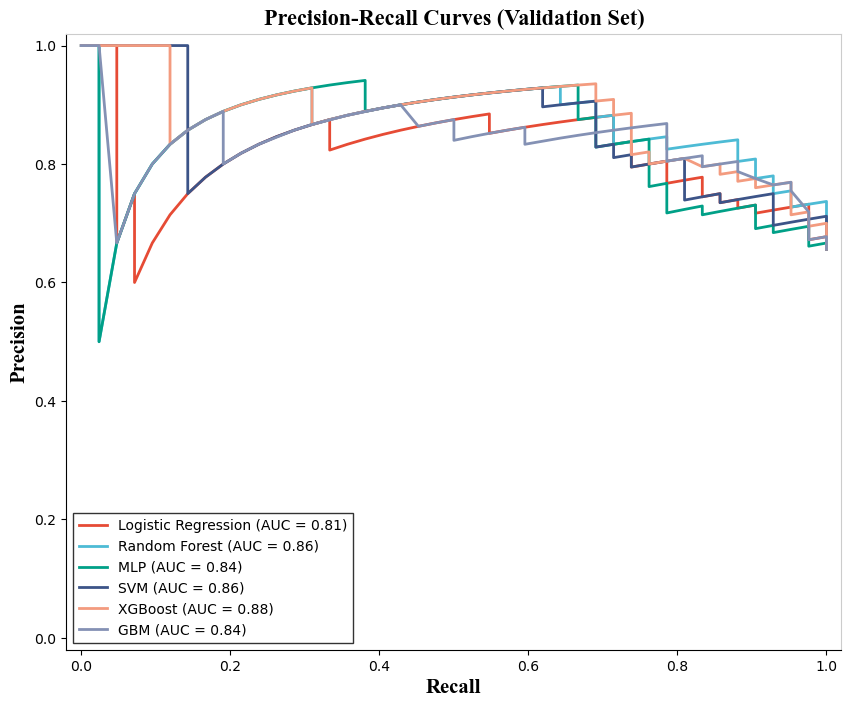

验证集 PR 曲线绘制完成！已保存至 '模型对比/pr_curves_val.png'


In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, auc
import os

# ==========================================
# 1. 准备工作
# ==========================================

# 确保颜色字典存在
nature_colors = {
    'Logistic Regression': '#E64B35',  # 红
    'Random Forest':       '#4DBBD5',  # 蓝
    'MLP':                 '#00A087',  # 绿
    'SVM':                 '#3C5488',  # 深蓝
    'XGBoost':             '#F39B7F',  # 橙
    'GBM':                 '#8491B4'   # 灰蓝
}

# 确保模型字典存在
models = {
    'Logistic Regression': log_reg,
    'Random Forest': rf,
    'MLP': mlp,
    'SVM': svm,
    'XGBoost': xgb_model,
    'GBM': lgb_model
}

# ==========================================
# 2. 定义绘图函数
# ==========================================

def plot_pr_curve(ax, y_true, y_scores, label, color):
    """绘制PR曲线"""
    # 计算 Precision-Recall 曲线
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    
    # 计算 AUC 值
    auc_score = auc(recall, precision)
    
    # 绘制 PR 曲线 (使用传入的 color)
    ax.plot(recall, precision, label=f'{label} (AUC = {auc_score:.2f})', color=color, lw=2)

    # 图表配置
    ax.set_xlabel("Recall", fontdict={'family': 'Times New Roman', 'fontsize': 15, 'weight': 'bold'})
    ax.set_ylabel("Precision", fontdict={'family': 'Times New Roman', 'fontsize': 15, 'weight': 'bold'})
    
    # 设置边框颜色
    ax.spines['right'].set_color((0.8, 0.8, 0.8))
    ax.spines['top'].set_color((0.8, 0.8, 0.8))
    
    # 设置图例位置
    ax.legend(loc='lower left', frameon=True, fancybox=False, edgecolor='black', fontsize=10)

    return ax

# ==========================================
# 3. 绘制验证集的 PR 曲线
# ==========================================

fig_val, ax_val = plt.subplots(figsize=(10, 8))

# 循环绘制每个模型 (使用 X_val, y_val)
for name, model in models.items():
    # 1. 获取预测概率
    if name == 'GBM':
        # LightGBM 原生接口
        y_scores = model.predict(X_val, num_iteration=model.best_iteration)
    else:
        # Sklearn 接口
        y_scores = model.predict_proba(X_val)[:, 1]
    
    # 2. 调用函数绘图 (应用 Nature 配色)
    plot_pr_curve(ax_val, y_val, y_scores, name, color=nature_colors[name])

# ==========================================
# 4. 全局样式调整与保存
# ==========================================

# 设置标题
ax_val.set_title('Precision-Recall Curves (Validation Set)', fontdict={'family': 'Times New Roman', 'fontsize': 16, 'weight': 'bold'})

# 移除网格线 (保持风格一致)
ax_val.grid(False)

# 设置坐标轴范围
ax_val.set_xlim([-0.02, 1.02])
ax_val.set_ylim([-0.02, 1.02])

# 保存图像
if not os.path.exists("模型对比"):
    os.makedirs("模型对比")

plt.savefig("模型对比/pr_curves_val.png", dpi=300)
plt.show()

print("验证集 PR 曲线绘制完成！已保存至 '模型对比/pr_curves_val.png'")

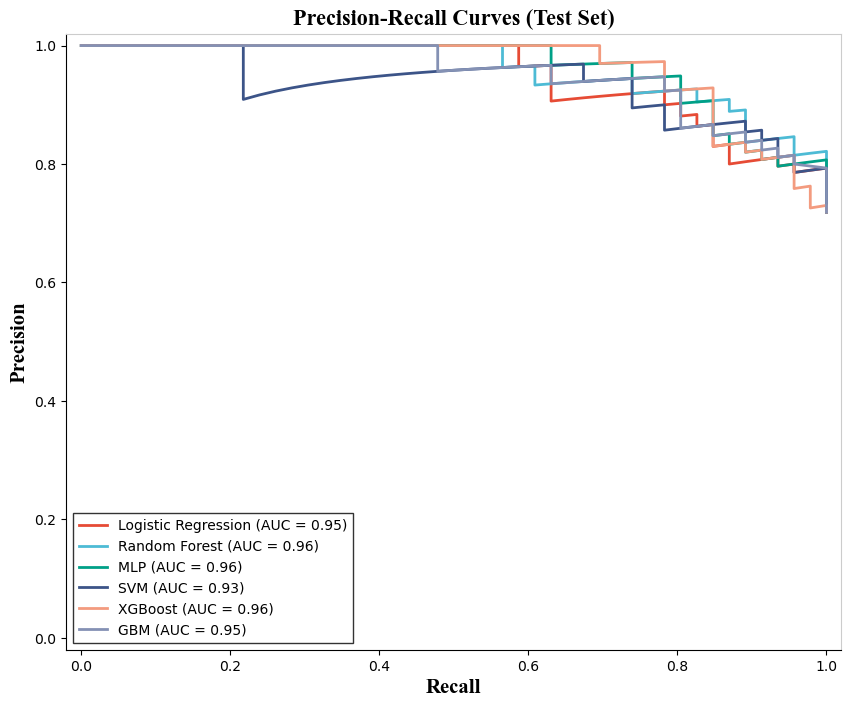

测试集 PR 曲线绘制完成！已保存至 '模型对比/pr_curves_test.png'


In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, auc
import os

# ==========================================
# 1. 准备工作
# ==========================================

# 确保颜色字典存在
nature_colors = {
    'Logistic Regression': '#E64B35',  # 红
    'Random Forest':       '#4DBBD5',  # 蓝
    'MLP':                 '#00A087',  # 绿
    'SVM':                 '#3C5488',  # 深蓝
    'XGBoost':             '#F39B7F',  # 橙
    'GBM':                 '#8491B4'   # 灰蓝
}

# 确保模型字典存在
models = {
    'Logistic Regression': log_reg,
    'Random Forest': rf,
    'MLP': mlp,
    'SVM': svm,
    'XGBoost': xgb_model,
    'GBM': lgb_model
}

# ==========================================
# 2. 定义绘图函数 (带颜色参数)
# ==========================================

def plot_pr_curve(ax, y_true, y_scores, label, color):
    """绘制PR曲线"""
    # 计算 Precision-Recall 曲线
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    # 计算 AUC 值
    auc_score = auc(recall, precision)

    # 绘制 PR 曲线 (使用传入的 color)
    ax.plot(recall, precision, label=f'{label} (AUC = {auc_score:.2f})', color=color, lw=2)

    # 图表配置
    ax.set_xlabel("Recall", fontdict={'family': 'Times New Roman', 'fontsize': 15, 'weight': 'bold'})
    ax.set_ylabel("Precision", fontdict={'family': 'Times New Roman', 'fontsize': 15, 'weight': 'bold'})
    
    # 设置边框颜色
    ax.spines['right'].set_color((0.8, 0.8, 0.8))
    ax.spines['top'].set_color((0.8, 0.8, 0.8))
    
    # 设置图例位置
    ax.legend(loc='lower left', frameon=True, fancybox=False, edgecolor='black', fontsize=10)

    return ax

# ==========================================
# 3. 绘制测试集的 PR 曲线
# ==========================================

fig_test, ax_test = plt.subplots(figsize=(10, 8))

# 循环绘制每个模型 (使用 X_test, y_test)
for name, model in models.items():
    # 1. 获取预测概率
    if name == 'GBM':
        # LightGBM 原生接口
        y_scores = model.predict(X_test, num_iteration=model.best_iteration)
    else:
        # Sklearn 接口
        y_scores = model.predict_proba(X_test)[:, 1]
    
    # 2. 调用函数绘图 (应用 Nature 配色)
    plot_pr_curve(ax_test, y_test, y_scores, name, color=nature_colors[name])

# ==========================================
# 4. 全局样式调整与保存
# ==========================================

# 设置标题
ax_test.set_title('Precision-Recall Curves (Test Set)', fontdict={'family': 'Times New Roman', 'fontsize': 16, 'weight': 'bold'})

# 移除网格线 (保持风格一致)
ax_test.grid(False)

# 设置坐标轴范围
ax_test.set_xlim([-0.02, 1.02])
ax_test.set_ylim([-0.02, 1.02])

# 保存图像
if not os.path.exists("模型对比"):
    os.makedirs("模型对比")

plt.savefig("模型对比/pr_curves_test.png", dpi=300)
plt.show()

print("测试集 PR 曲线绘制完成！已保存至 '模型对比/pr_curves_test.png'")

<Figure size 1000x800 with 0 Axes>

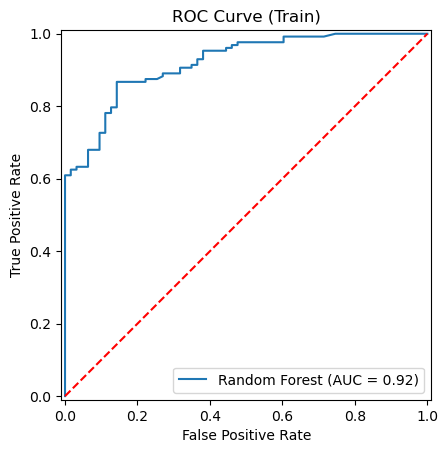

In [15]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# 训练集 ROC
plt.figure(figsize=(10,8))

# 绘制 ROC
RocCurveDisplay.from_estimator(rf, X_train, y_train, name='Random Forest')

# 随机线
plt.plot([0, 1], [0, 1], linestyle='--', color='r')

# 图形设置
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Train)')
plt.legend(loc='lower right')

# 保存
plt.savefig("最优模型/roc_curves_train.png")
plt.show()


<Figure size 1000x800 with 0 Axes>

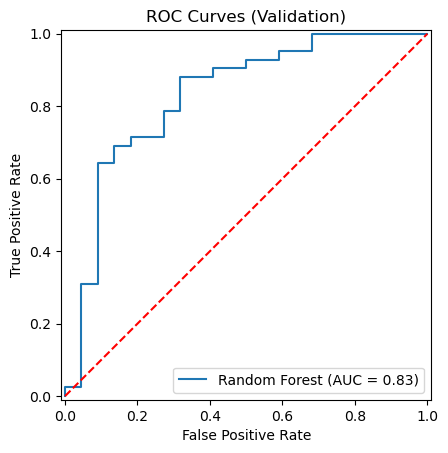

In [16]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# 验证集
plt.figure(figsize=(10,8))

# 正确使用 name=
RocCurveDisplay.from_estimator(rf, X_val, y_val, name='Random Forest')

plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Validation)')
plt.legend(loc='lower right')

plt.savefig("最优模型/roc_curves_val.png")
plt.show()

<Figure size 1000x800 with 0 Axes>

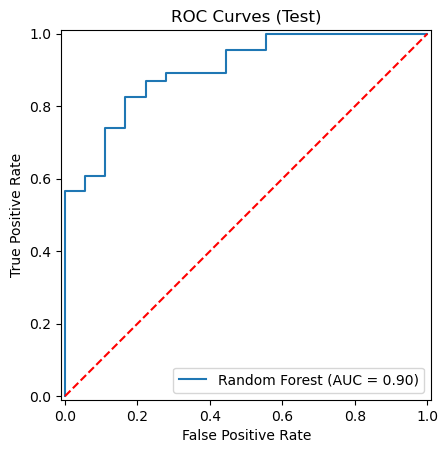

In [17]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
# 测试集
plt.figure(figsize=(10,8))
RocCurveDisplay.from_estimator(rf, X_test, y_test, name='Random Forest')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Test)')
plt.legend(loc='lower right')
plt.savefig("最优模型/roc_curves_test.png")
plt.show()

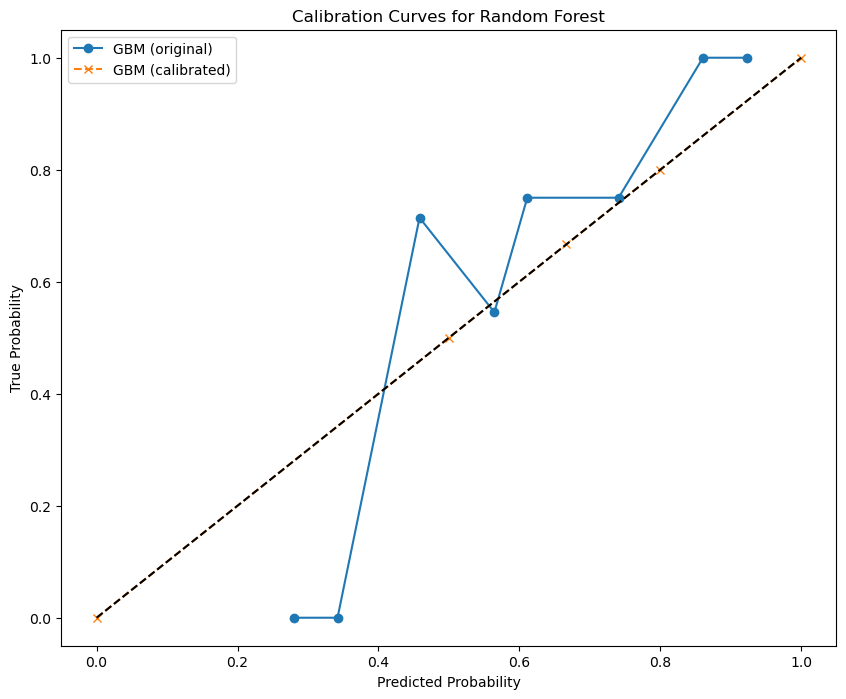

In [18]:
#### 最佳模型测试集校准曲线
from sklearn.isotonic import IsotonicRegression  # 导入单调回归类
from sklearn.calibration import calibration_curve  # 导入校准曲线计算函数


# 计算每个模型的预测概率
def get_predictions(model, X, model_name):
    # 使用模型对特征X进行预测，并返回预测的概率值（取第二列，即正类的概率）
    return model.predict_proba(X)[:, 1]


# 绘制校准曲线
plt.figure(figsize=(10, 8))  # 创建一个大小为10x8的图形窗口

# 获取rf模型在测试集上的预测概率
y_pred = get_predictions(rf, X_test, name)
y_pred = np.clip(y_pred, 0, 1)  # 将预测值限制在 [0, 1] 范围内，防止超出范围

# 进行Isotonic Regression校准
iso_reg = IsotonicRegression(out_of_bounds='clip')  # 创建IsotonicRegression对象，并设置超出边界的处理方式为裁剪
y_pred_calibrated = iso_reg.fit_transform(y_pred, y_test)  # 进行拟合并变换预测值，得到校准后的预测值

# 原始模型的校准曲线
prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10)  # 计算原始预测的校准曲线
plt.plot(prob_pred, prob_true, marker='o', label=f'{name} (original)')  # 绘制原始模型的校准曲线

# 校准后的模型的校准曲线
prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_pred_calibrated, n_bins=10)  # 计算校准后预测的校准曲线
plt.plot(prob_pred_cal, prob_true_cal, marker='x', linestyle='--', label=f'{name} (calibrated)')  # 绘制校准后的模型的校准曲线

plt.plot([0, 1], [0, 1], linestyle='--', color='black')  # 绘制对角线（理想模型的参考线）
plt.xlabel('Predicted Probability')  # 设置x轴标签
plt.ylabel('True Probability')  # 设置y轴标签
plt.title('Calibration Curves for Random Forest')  # 设置图形标题
plt.legend(loc='best')  # 添加图例，并将其放置在最佳位置

# 保存为PDF文件
plt.savefig('最优模型/calibration_curves_Random Forest.png')  # 保存图形为PDF文件
plt.show()  # 显示图形

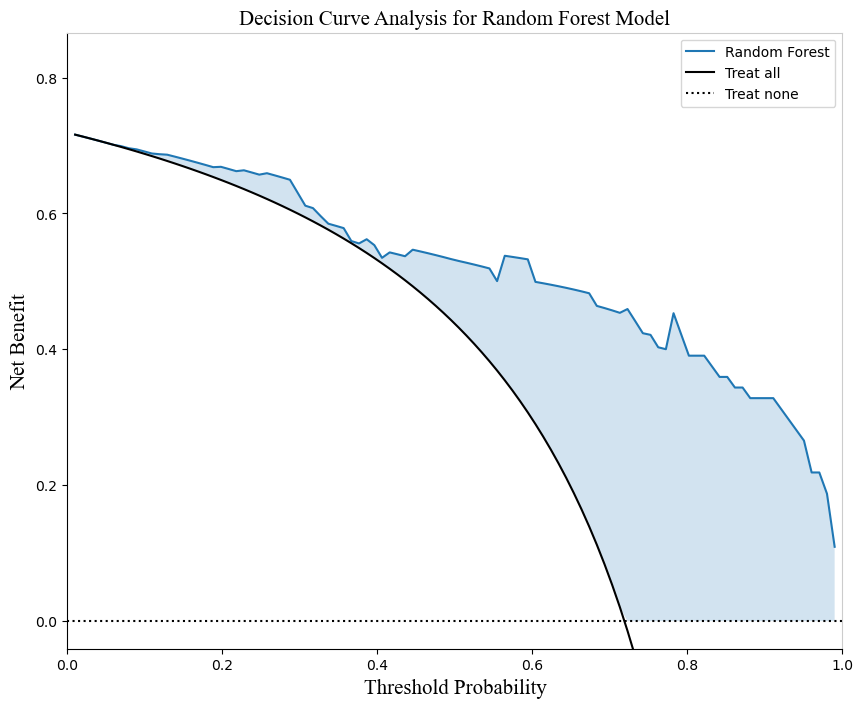

In [19]:
#### 绘制测试集MLP模型的DCA曲线
fig, ax = plt.subplots(figsize=(10, 8))  # 创建一个10x8英寸的图形和坐标轴

# 计算 Treat All 的净收益
net_benefit_all = calculate_net_benefit_all(thresh_group, y_test)  # 计算在所有阈值下的“Treat All”策略的净收益

# 获取MLP模型的预测分数
if hasattr(mlp, "predict_proba"):  # 检查MLP模型是否具有predict_proba方法
    y_pred_score = mlp.predict_proba(X_test)[:, 1]  # 获取MLP模型在测试集上的预测概率
else:  # 如果模型没有predict_proba方法
    y_pred_score = mlp.decision_function(X_test)  # 获取MLP模型在测试集上的决策函数分数

# 计算MLP模型的净收益
net_benefit_model = calculate_net_benefit_model(thresh_group, y_pred_score, y_test)  # 计算MLP模型在不同阈值下的净收益

# 定义绘制DCA曲线的函数
def plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all, label):
    """绘制DCA曲线"""
    # 绘制模型的DCA曲线
    ax.plot(thresh_group, net_benefit_model, label=f'{label}')
    
    # 绘制 Treat All 的净收益线
    ax.plot(thresh_group, net_benefit_all, color='black', label='Treat all')
    
    # 绘制 Treat None 的净收益线
    ax.plot((0, 1), (0, 0), color='black', linestyle=':', label='Treat none')
    
    # 填充 DCA 曲线与 Treat None 之间的区域
    y2 = np.maximum(net_benefit_all, 0)
    y1 = np.maximum(net_benefit_model, y2)
    ax.fill_between(thresh_group, y1, y2, alpha=0.2)

    # 图表配置
    ax.set_xlim(0, 1)  # x轴范围
    ax.set_ylim(net_benefit_model.min() - 0.15, net_benefit_model.max() + 0.15)  # y轴范围
    ax.set_xlabel('Threshold Probability', fontdict={'family': 'Times New Roman', 'fontsize': 15})  # x轴标签
    ax.set_ylabel('Net Benefit', fontdict={'family': 'Times New Roman', 'fontsize': 15})  # y轴标签
    # ax.grid('major')  # 添加网格线
    ax.spines['right'].set_color((0.8, 0.8, 0.8))  # 设置右边框的颜色
    ax.spines['top'].set_color((0.8, 0.8, 0.8))  # 设置上边框的颜色
    ax.legend(loc='upper right')  # 添加图例

    return ax

# 绘制DCA曲线
ax = plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all, "Random Forest")  # 使用plot_DCA函数绘制DCA曲线

# 添加标题
plt.title("Decision Curve Analysis for Random Forest Model", fontdict={'family': 'Times New Roman', 'fontsize': 15})  # 添加图表标题

# 最后保存图像并显示
plt.savefig("最优模型/dca_curve_Random Forest.png")  # 保存图像为PDF文件
plt.show()  # 显示图像

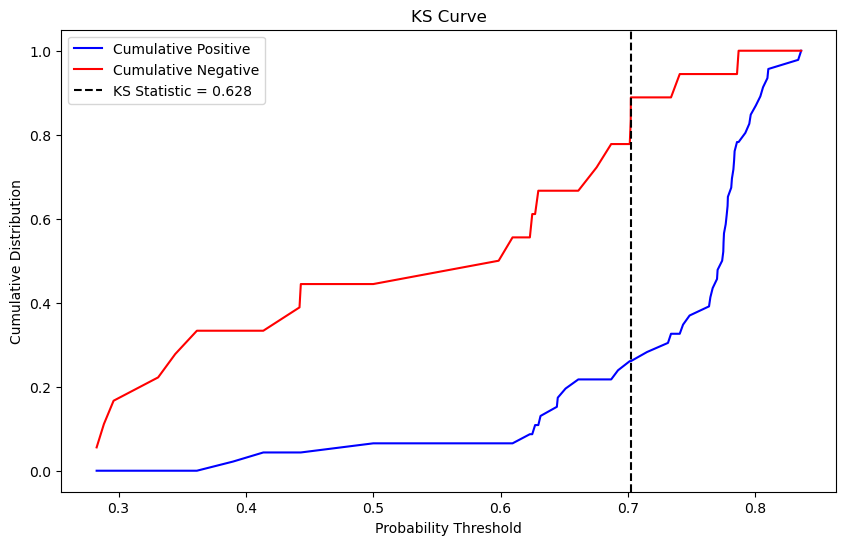

In [20]:
#### 绘制测试集数据的 KS 曲线
# 定义绘制 KS 曲线的函数
def plot_ks_curve(y_true, y_proba):
    # 将实际值和预测概率值整理成 DataFrame，并按预测概率值进行排序
    data = pd.DataFrame({'y_true': y_true, 'y_proba': y_proba})
    data = data.sort_values(by='y_proba')

    # 计算正类的累积分布函数（CDF）
    data['cum_pos'] = np.cumsum(data['y_true']) / np.sum(data['y_true'])
    # 计算负类的累积分布函数（CDF）
    data['cum_neg'] = np.cumsum(1 - data['y_true']) / np.sum(1 - data['y_true'])

    # 计算 KS 统计量，即正类和负类累积分布函数的最大差值
    ks_stat = np.max(np.abs(data['cum_pos'] - data['cum_neg']))
    # 找到 KS 统计量出现的索引位置
    ks_stat_index = np.argmax(np.abs(data['cum_pos'] - data['cum_neg']))

    # 绘制 KS 曲线
    plt.figure(figsize=(10, 6))  # 设置绘图的大小
    plt.plot(data['y_proba'], data['cum_pos'], label='Cumulative Positive', color='b')  # 绘制正类的累积分布曲线
    plt.plot(data['y_proba'], data['cum_neg'], label='Cumulative Negative', color='r')  # 绘制负类的累积分布曲线
    plt.axvline(data['y_proba'].iloc[ks_stat_index], color='k', linestyle='--', label=f'KS Statistic = {ks_stat:.3f}')  # 绘制 KS 统计量的垂直线
    plt.title('KS Curve')  # 设置图表标题
    plt.xlabel('Probability Threshold')  # 设置 x 轴标签
    plt.ylabel('Cumulative Distribution')  # 设置 y 轴标签
    plt.legend(loc='best')  # 添加图例
    plt.savefig('最优模型/MLP_KS.png')  # 保存图表为 PDF 文件
    plt.show()  # 显示图表

# 计算和绘制 KS 曲线
y_test_proba = svm.predict_proba(X_test)[:, 1]  # 获取测试集样本的预测概率
plot_ks_curve(y_test, y_test_proba)  # 调用函数绘制 KS 曲线

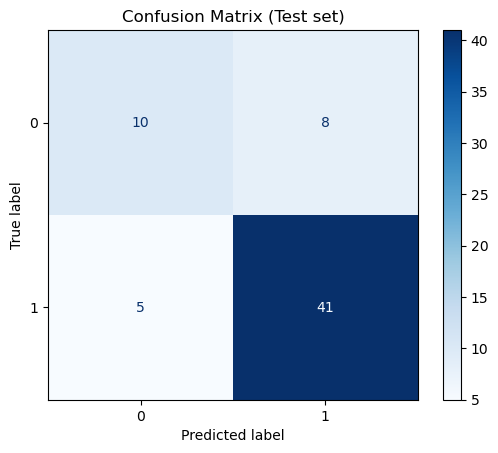

In [21]:
#### 测试集的混淆矩阵
# 导入必要的库和模块
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # 导入混淆矩阵和混淆矩阵显示工具

# 使用训练好的模型对测试集进行预测
y_test_pred = rf.predict(X_test)  # 预测测试集的标签

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_test_pred)  # 计算实际标签和预测标签之间的混淆矩阵

# 创建混淆矩阵显示对象
disp = ConfusionMatrixDisplay(confusion_matrix=cm)  # 初始化混淆矩阵显示对象

# 绘制混淆矩阵
disp.plot(cmap=plt.cm.Blues)  # 绘制混淆矩阵，使用蓝色渐变色图

# 设置图表标题
plt.title('Confusion Matrix (Test set)')  # 设置图表标题为“测试集混淆矩阵”

# 保存图表为 PDF 文件
plt.savefig('最优模型/mlp_Confusion_test.png')  # 将混淆矩阵图表保存为 PDF 文件

# 显示图表
plt.show()  # 显示绘制的混淆矩阵图表

In [22]:
import sys

# 安装 shap 到当前 Notebook 内核
!{sys.executable} -m pip install shap --upgrade
import shap  # 导入 SHAP 库，用于模型解释

# 使用 KernelExplainer 解释模型
explainer = shap.KernelExplainer(rf.predict_proba, X_test)  # 创建 KernelExplainer 对象，传入模型的预测概率函数和训练数据

# 计算 SHAP 值
shap_values = explainer.shap_values(X_test, nsamples=100)  # 计算测试集的 SHAP 值，使用 nsamples 参数控制采样次数

Defaulting to user installation because normal site-packages is not writeable


  0%|          | 0/64 [00:00<?, ?it/s]

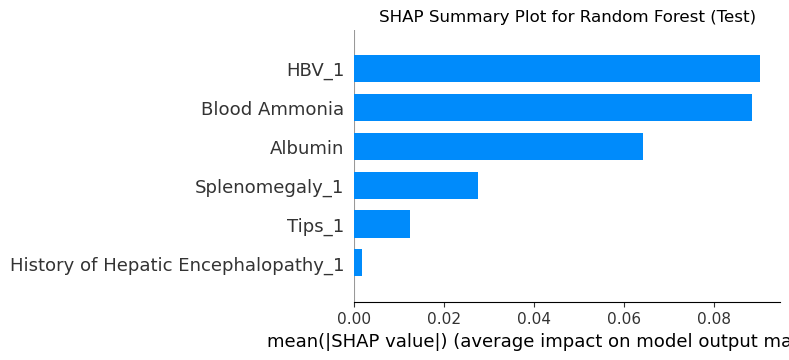

In [23]:
# 条形图
shap_values_class_1 = shap_values[:,:,1]  # 选择第二个类的 SHAP 值，因为索引从 0 开始，假设这是正类的 SHAP 值

# 创建绘图对象
plt.figure()  # 初始化绘图

# 绘制 SHAP 值的汇总条形图
shap.summary_plot(shap_values_class_1, X_test, plot_type="bar", show=False)  # 使用条形图展示 SHAP 值的汇总信息，show=False 表示不立即显示图形

# 设置图表标题
plt.title(f'SHAP Summary Plot for Random Forest (Test)')  # 设置图表标题为“MLP 测试集的 SHAP 汇总图”

# 调整布局以适应标题
plt.tight_layout(rect=[0, 0, 1, 0.95])  # 调整布局，确保标题不被遮挡

# 保存图表为 PDF 文件
plt.savefig(f"最优模型/mlp_shap_summary_plot.png")  # 将 SHAP 汇总条形图保存为 PDF 文件

# 显示图表
plt.show()  # 显示绘制的 SHAP 汇总条形图

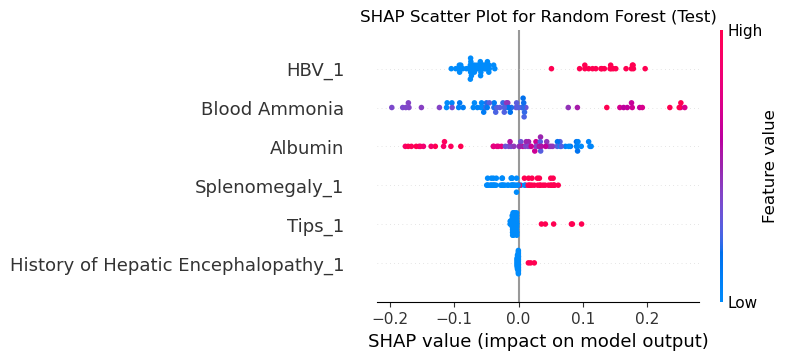

In [24]:
# 散点图
plt.figure()  # 初始化绘图

# 绘制 SHAP 值的散点图
shap.summary_plot(shap_values_class_1, X_test, plot_type="dot", show=False)  # 使用散点图展示 SHAP 值的汇总信息，show=False 表示不立即显示图形

# 设置图表标题
plt.title(f'SHAP Scatter Plot for Random Forest (Test)')  # 设置图表标题为“MLP 测试集的 SHAP 散点图”

# 调整布局以适应标题
plt.tight_layout(rect=[0, 0, 1, 0.95])  # 调整布局，确保标题不被遮挡

# 保存图表为 PDF 文件
plt.savefig(f"最优模型/Random Forest_shap_scatter_test_plot.png")  # 将 SHAP 散点图保存为 PDF 文件

# 显示图表
plt.show()  # 显示绘制的 SHAP 散点图

In [25]:
# 力图
sample_index = 1  # 设置要绘制 SHAP 力图的样本索引

# 初始化 SHAP 可视化工具
shap.initjs()  # 初始化 JavaScript 可视化工具，以便在浏览器中显示 SHAP 图

# 创建 SHAP 力图
force_plot = shap.force_plot(explainer.expected_value[0], shap_values_class_1[sample_index,:], X_test.iloc[sample_index,:], feature_names=X_test.columns)  
# 生成 SHAP 力图，显示样本的 SHAP 值及其对模型预测的影响
# explainer.expected_value[0] 是模型预测的期望值
# shap_values_class_1[sample_index,:] 是指定样本的 SHAP 值
# X_test.iloc[sample_index,:] 是指定样本的特征值
# feature_names=X_test.columns 提供特征名称用于图表中

# 保存 force plot 为 HTML 文件
shap.save_html("最优模型/mlp_shap_force_plot{}.html".format(sample_index), force_plot)  
# 将 SHAP 力图保存为 HTML 文件，文件名中包含样本索引

<Figure size 640x480 with 0 Axes>

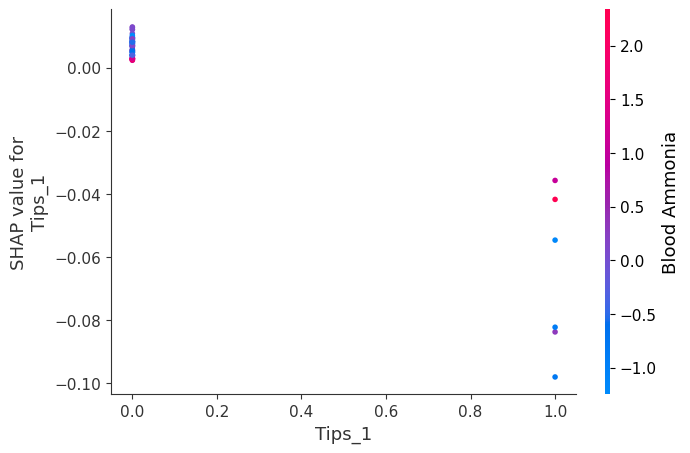

In [27]:
i = 2  # 特征索引，指定要绘制依赖图的特征

# 创建绘图对象
plt.figure()  # 初始化绘图

# 绘制 SHAP 依赖图
shap.dependence_plot(i, shap_values[:, :, 0], X_test, show=False)  # 绘制指定特征的依赖图，shap_values[:, :, 0] 是第一个类别的 SHAP 值

# 保存依赖图为 PDF 文件
plt.savefig("最优模型/mlp_shap_scatter_feature_plot{}.png".format(i))  # 将依赖图保存为 PDF 文件，文件名中包含特征索引

# 显示图表
plt.show()  # 显示绘制的 SHAP 依赖图

In [28]:
# 计算预测概率
pred_probs = mlp.predict_proba(X_test)  # 获取测试集样本的预测概率

# 获取预测为正样本的索引 (假设正类为类 1)
positive_indices = [i for i in range(len(pred_probs)) if pred_probs[i][1] >= 0.5]  
# 遍历预测概率，选择预测概率大于等于 0.5 的样本索引作为正样本

# 获取预测为负样本的索引 (假设负类为类 0)
negative_indices = [i for i in range(len(pred_probs)) if pred_probs[i][1] < 0.5]  
# 遍历预测概率，选择预测概率小于 0.5 的样本索引作为负样本

# 创建正样本的 shap.Explanation 对象
positive_explanations = shap.Explanation(values=shap_values_class_1[positive_indices],  
                                         base_values=explainer.expected_value[1],  
                                         data=X_test.iloc[positive_indices])  
# 创建包含正样本的 SHAP 解释对象，指定 SHAP 值、基准值和特征数据

# 绘制正样本的 SHAP 力度图
force_plot_pos = shap.force_plot(positive_explanations.base_values, positive_explanations.values, positive_explanations.data)  
# 绘制正样本的 SHAP 力度图

# 保存 force plot 为 HTML 文件
shap.save_html("最优模型/shap_force_plot_positive_indices.html", force_plot_pos)  
# 将正样本的 SHAP 力度图保存为 HTML 文件

# 创建负样本的 shap.Explanation 对象
negative_explanations = shap.Explanation(values=shap_values_class_1[negative_indices],  
                                         base_values=explainer.expected_value[1],  
                                         data=X_test.iloc[negative_indices])  
# 创建包含负样本的 SHAP 解释对象，指定 SHAP 值、基准值和特征数据

# 绘制负样本的 SHAP 力度图
force_plot_neg = shap.force_plot(negative_explanations.base_values, negative_explanations.values, negative_explanations.data)  
# 绘制负样本的 SHAP 力度图

# 保存 force plot 为 HTML 文件
shap.save_html("最优模型/shap_force_plot_negative_indices.html", force_plot_neg)  
# 将负样本的 SHAP 力度图保存为 HTML 文件

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# ==========================================
# 4. 全面评估指标计算 (AUC, Acc, Pre, Sen, Spe, F1)
# ==========================================

print("正在计算所有数据集的详细指标...")

# 1. 将所有模型整理到字典中，方便循环
models_dict = {
    'Logistic Regression': log_reg,
    'Random Forest': rf,
    'MLP': mlp,
    'SVM': svm,
    'XGBoost': xgb_model,
    'GBM': lgb_model
}

# 2. 定义数据集列表
datasets = [
    ('Train', X_train, y_train),
    ('Validation', X_val, y_val),
    ('Test', X_test, y_test)
]

# 3. 定义计算单次指标的函数
def calculate_metrics(model, X, y, model_name, dataset_name):
    # --- 获取预测值 ---
    if model_name == 'GBM':
        # LightGBM 原生接口 predict 返回的是概率
        y_prob = model.predict(X, num_iteration=model.best_iteration)
        y_pred = (y_prob > 0.5).astype(int) # 阈值设为0.5转为二分类
    else:
        # Sklearn 接口
        y_prob = model.predict_proba(X)[:, 1]
        y_pred = model.predict(X)
    
    # --- 计算基础指标 ---
    auc_val = roc_auc_score(y, y_prob)
    acc = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, zero_division=0)
    sensitivity = recall_score(y, y_pred, zero_division=0) # Recall 就是 Sensitivity
    f1 = f1_score(y, y_pred, zero_division=0)
    
    # --- 计算 Specificity (特异度) ---
    # 混淆矩阵: tn, fp, fn, tp
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    # 特异度公式: TN / (TN + FP)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    return {
        'Model': model_name,
        'Dataset': dataset_name,
        'AUC': round(auc_val, 4),
        'Accuracy': round(acc, 4),
        'Precision': round(precision, 4),
        'Sensitivity': round(sensitivity, 4),
        'Specificity': round(specificity, 4),
        'F1 Score': round(f1, 4)
    }

# 4. 循环计算所有结果
results_list = []

for dataset_name, X_data, y_data in datasets:
    for model_name, model in models_dict.items():
        metrics = calculate_metrics(model, X_data, y_data, model_name, dataset_name)
        results_list.append(metrics)

# 5. 转换为 DataFrame 并展示
metrics_df = pd.DataFrame(results_list)

# 调整列顺序，使其更易读
metrics_df = metrics_df[['Dataset', 'Model', 'AUC', 'Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1 Score']]

print("\n========== 模型性能综合评估表 ==========")
print(metrics_df)

# 6. 保存结果到 CSV
import os
if not os.path.exists("模型对比"):
    os.makedirs("模型对比")

save_path = "模型对比/all_models_metrics_detailed.csv"
metrics_df.to_csv(save_path, index=False)

print(f"\n所有指标已保存至: {save_path}")

正在计算所有数据集的详细指标...

========== 模型性能综合评估表 ==========
       Dataset                Model     AUC  Accuracy  Precision  Sensitivity  \
0        Train  Logistic Regression  0.7895    0.7173     0.7500       0.8672   
1        Train        Random Forest  0.9198    0.8325     0.8243       0.9531   
2        Train                  MLP  0.9006    0.8220     0.8790       0.8516   
3        Train                  SVM  0.8344    0.7173     0.7372       0.8984   
4        Train              XGBoost  0.9750    0.9005     0.8978       0.9609   
5        Train                  GBM  0.8672    0.8115     0.8108       0.9375   
6   Validation  Logistic Regression  0.7576    0.7031     0.7447       0.8333   
7   Validation        Random Forest  0.8279    0.7812     0.7917       0.9048   
8   Validation                  MLP  0.7695    0.7031     0.7805       0.7619   
9   Validation                  SVM  0.7835    0.7188     0.7500       0.8571   
10  Validation              XGBoost  0.8198    0.7656     

In [30]:
import joblib
import os

if not os.path.exists("saved_models"):
    os.makedirs("saved_models")

# 1. 保存所有模型
joblib.dump(log_reg, 'saved_models/log_reg.pkl')
joblib.dump(rf, 'saved_models/rf.pkl')
joblib.dump(mlp, 'saved_models/mlp.pkl')
joblib.dump(svm, 'saved_models/svm.pkl')
joblib.dump(xgb_model, 'saved_models/xgb.pkl')
joblib.dump(lgb_model, 'saved_models/lgb.pkl')

# 2. 【非常重要】保存预处理器
# 如果没有这些，新输入的数据就无法转换成模型能读懂的格式
joblib.dump(scaler, 'saved_models/scaler.pkl')
joblib.dump(encoder, 'saved_models/encoder.pkl')

# 3. 保存列名信息（用于确保输入顺序一致）
# 数值列名
joblib.dump(val_cols, 'saved_models/val_cols.pkl')
# 分类列名
joblib.dump(categorical_cols, 'saved_models/cat_cols.pkl')
# 最终进入模型的所有特征列名
joblib.dump(list(X_train.columns), 'saved_models/model_features.pkl')

print("所有模型和预处理工具已保存！")

所有模型和预处理工具已保存！


In [31]:
pip install streamlit

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [32]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib
from PIL import Image

# ============================================
# 1. 页面配置与加载资源
# ============================================
st.set_page_config(page_title="肝硬化CHE风险预测系统", layout="wide")

st.title("🏥 肝硬化患者 CHE 风险预测系统")
st.markdown("基于多模态机器学习模型的临床决策支持工具")

# 【修改1】删除了这里的 plt.savefig，因为它不属于网页运行逻辑

# 加载模型和工具的函数（使用缓存加快速度）
@st.cache_resource
def load_assets():
    # 确保你的 saved_models 文件夹和 app.py 在同一目录下
    models = {
        'Logistic Regression': joblib.load('saved_models/log_reg.pkl'),
        'Random Forest': joblib.load('saved_models/rf.pkl'),
        'MLP': joblib.load('saved_models/mlp.pkl'),
        'SVM': joblib.load('saved_models/svm.pkl'),
        'XGBoost': joblib.load('saved_models/xgb.pkl'),
        'GBM': joblib.load('saved_models/lgb.pkl')
    }
    scaler = joblib.load('saved_models/scaler.pkl')
    encoder = joblib.load('saved_models/encoder.pkl')
    val_cols = joblib.load('saved_models/val_cols.pkl')
    cat_cols = joblib.load('saved_models/cat_cols.pkl')
    model_features = joblib.load('saved_models/model_features.pkl')
    return models, scaler, encoder, val_cols, cat_cols, model_features

# 加载资源
try:
    models, scaler, encoder, val_cols, cat_cols, model_features = load_assets()
except FileNotFoundError:
    st.error("错误：找不到模型文件。请确保 'saved_models' 文件夹存在且包含 .pkl 文件。")
    st.stop()

# ============================================
# 2. 侧边栏：输入患者信息
# ============================================
st.sidebar.header("输入患者临床参数")

def user_input_features():
    inputs = {}
    
    # 数值型变量输入
    st.sidebar.subheader("数值指标")
    inputs['Blood Ammonia'] = st.sidebar.number_input("Blood Ammonia (血氨)", min_value=0.0, value=50.0)
    inputs['Albumin'] = st.sidebar.number_input("Albumin (白蛋白)", min_value=0.0, value=35.0)
    
    # 分类变量输入
    st.sidebar.subheader("临床特征")
    # 假设 0代表无/No，1代表有/Yes
    inputs['Tips'] = st.sidebar.selectbox("Tips", options=[0, 1]) 
    inputs['HBV'] = st.sidebar.selectbox("HBV Infection", options=[0, 1])
    inputs['Splenomegaly'] = st.sidebar.selectbox("Splenomegaly (脾肿大)", options=[0, 1])
    inputs['History of Hepatic Encephalopathy'] = st.sidebar.selectbox("History of HE (肝性脑病史)", options=[0, 1])
    
    return pd.DataFrame([inputs])

input_df = user_input_features()

# 展示输入数据
st.subheader("1. 患者当前参数")
st.dataframe(input_df)

# ============================================
# 3. 数据预处理与预测
# ============================================
if st.button("开始预测", type="primary"):
    try:
        # 1. 分离数值和分类
        input_val = input_df[val_cols]
        input_cat = input_df[cat_cols]
        
        # 2. 标准化数值特征
        input_val_scaled = scaler.transform(input_val)
        input_val_df = pd.DataFrame(input_val_scaled, columns=val_cols)
        
        # 3. 独热编码分类特征
        input_cat_encoded = encoder.transform(input_cat)
        input_cat_df = pd.DataFrame(input_cat_encoded, columns=encoder.get_feature_names_out(cat_cols))
        
        # 4. 拼接
        final_input = pd.concat([input_val_df, input_cat_df], axis=1)
        
        # 5. 补齐缺失列 (对齐 XGBoost/GBM 特征)
        for col in model_features:
            if col not in final_input.columns:
                final_input[col] = 0
        final_input = final_input[model_features]
        
        # 转换类型
        final_input = final_input.astype(float)

        # ============================================
        # 4. 模型预测与展示
        # ============================================
        st.subheader("2. 风险预测结果")
        
        col1, col2, col3 = st.columns(3)
        
        # 定义卡片展示函数
        def show_prediction(model_name, model, col):
            if model_name == 'GBM':
                prob = model.predict(final_input)[0]
            else:
                prob = model.predict_proba(final_input)[0][1]
            
            risk_percent = prob * 100
            
            # 颜色逻辑
            color = "green" if risk_percent < 30 else "orange" if risk_percent < 70 else "red"
            
            col.markdown(f"""
            <div style="padding:10px; border-radius:10px; border:1px solid #ddd; text-align:center; background-color: #f9f9f9;">
                <h4 style="margin:0; color: #333;">{model_name}</h4>
                <h2 style="color:{color}; margin:10px 0;">{risk_percent:.1f}%</h2>
                <p style="margin:0; color: #666;">患病概率</p>
            </div>
            """, unsafe_allow_html=True)

        # 展示主要模型
        show_prediction('Random Forest', models['Random Forest'], col1)
        show_prediction('XGBoost', models['XGBoost'], col2)
        show_prediction('GBM', models['GBM'], col3)
        
        # 折叠面板展示所有详情
        with st.expander("查看所有模型预测详情"):
            all_probs = {}
            for name, model in models.items():
                if name == 'GBM':
                    p = model.predict(final_input)[0]
                else:
                    p = model.predict_proba(final_input)[0][1]
                all_probs[name] = f"{p*100:.2f}%"
            
            st.table(pd.DataFrame(list(all_probs.items()), columns=['模型名称', '预测概率']))

    except Exception as e:
        st.error(f"预测过程中发生错误: {e}")
        st.info("请检查 saved_models 文件是否完整，或输入数据是否异常。")

# ============================================
# 5. 模型性能展示 (静态图)
# ============================================
st.markdown("---")
st.subheader("3. 模型性能评估 (Nature Style)")

tab1, tab2, tab3, tab4 = st.tabs(["ROC 曲线", "校准曲线", "DCA 决策曲线", "PR 曲线"])

# 【修改2】确保这里读取的是 .png 文件，而不是 .pdf
# 请确保你的 "模型对比" 文件夹里有这些 png 图片
# 如果图片不存在，会显示错误提示

with tab1:
    try:
        st.image("模型对比/roc_curves_test_nature.png", caption="测试集 ROC 曲线")
    except:
        st.warning("未找到图片: roc_curves_test_nature.png (请先在 Notebook 中保存为 PNG)")

with tab2:
    try:
        st.image("模型对比/calibration_curves_test_nature.png", caption="测试集 校准曲线")
    except:
        st.warning("未找到图片: calibration_curves_test_nature.png")

with tab3:
    try:
        st.image("模型对比/dca_curves_test_nature.png", caption="测试集 DCA 决策曲线")
    except:
        st.warning("未找到图片: dca_curves_test_nature.png")

with tab4:
    try:
        st.image("模型对比/pr_curves_test.png", caption="测试集 PR 曲线")
    except:
        st.warning("未找到图片: pr_curves_test.png")

2025-12-15 14:09:41.054 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-15 14:09:41.057 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-15 14:09:45.115 
  command:

    streamlit run C:\ProgramData\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-12-15 14:09:45.116 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-15 14:09:45.117 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-15 14:09:45.118 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-15 14:09:45.121 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

In [ ]:
!streamlit run web_app.py